# Preprocessing all data

In [2]:
import psycopg2
import pandas as pd
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from numpy import concatenate
import seaborn as sns
import math
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import time

Using TensorFlow backend.


In [3]:
#classification 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [ ]:
connection = psycopg2.connect(user = "equipo7",
                            password = "DLgndXy2m4hbWH-qn-Co",
                            host= "ds4a-demo-instance.cssn41frspmj.us-east-1.rds.amazonaws.com",
                            port = "5432",
                            database = "anahuac")
cursor = connection.cursor()
def runquery(query):
    df=pd.read_sql(query,connection)
    return df

## Load data from database

In [5]:
where_date_clause = " WHERE date >= '2012-01-01' AND date < '2020-01-01' ORDER BY date";

sqlQuery_presion = "select * from processed_metrics.presion " + where_date_clause
df_presion = pd.DataFrame(runquery(sqlQuery_presion))

sqlQuery_radiacion = "select * from processed_metrics.radiacion " + where_date_clause
df_radiacion = pd.DataFrame(runquery(sqlQuery_radiacion))

sqlQuery_rama = "select * from processed_metrics.rama " + where_date_clause
df_rama = pd.DataFrame(runquery(sqlQuery_rama))

sqlQuery_redmet = "select * from processed_metrics.redmet " + where_date_clause
df_redmet = pd.DataFrame(runquery(sqlQuery_redmet))

sqlQuery_weather = "select * from processed_metrics.weather  " + where_date_clause
df_weather = pd.DataFrame(runquery(sqlQuery_weather))

# check shape and nulls

In [6]:
dfs = [df_presion, df_radiacion, df_rama, df_redmet, df_weather]
for df in dfs:
    print(df.head(5))
    print("Shape : {} ".format(df.shape))
    print("NaN : {}\n".format(df.isna().sum()))

                 date       fecha  hora factor     st
0 2012-01-01 00:00:00  2012-01-01     0     PA  587.0
1 2012-01-01 01:00:00  2012-01-01     1     PA  587.0
2 2012-01-01 02:00:00  2012-01-01     2     PA  587.0
3 2012-01-01 03:00:00  2012-01-01     3     PA  587.0
4 2012-01-01 04:00:00  2012-01-01     4     PA  587.0
Shape : (69384, 5) 
NaN : date      0
fecha     0
hora      0
factor    0
st        8
dtype: int64

                 date       fecha  hora factor   st
0 2012-01-01 00:00:00  2012-01-01     0    UVA  0.0
1 2012-01-01 00:00:00  2012-01-01     0    UVB  0.0
2 2012-01-01 01:00:00  2012-01-01     1    UVA  0.0
3 2012-01-01 01:00:00  2012-01-01     1    UVB  0.0
4 2012-01-01 02:00:00  2012-01-01     2    UVB  0.0
Shape : (140256, 5) 
NaN : date       0
fecha      0
hora       0
factor     0
st        22
dtype: int64

        date       fecha  hora factor     st0       st1       st2
0 2012-01-01  2012-01-01     0   PM25  69.400  58.00000  51.60000
1 2012-01-01  2012-01-01  

### Preprocess data 

In [7]:
def pivot_by_factor(df, index_table, column_table, value_table):
    df = pd.pivot_table(df, index = index_table, columns = column_table, values = value_table)
    df = df.sort_index(axis=1, level=1)
    df.columns = [f'{b}_{a}' for a, b in df.columns]
    df = df.reset_index()
    return df

In [8]:
#process pa
df_presion.rename(columns={'st': 'PA_st'}, inplace=True)
del df_presion['factor']


In [9]:
#process radiation
df_radiacion = pivot_by_factor(df_radiacion,["date","fecha","hora"],["factor"],["st"])

In [10]:
#process pollutants
df_rama = pivot_by_factor(df_rama,["date","fecha","hora"],["factor"],["st0","st1","st2"])

In [11]:
#process redmet
df_redmet = pivot_by_factor(df_redmet,["date","fecha","hora"],["factor"],["st0","st1","st2"])

In [ ]:
#weather is missing!!!!!
#-----------------------

In [12]:
dfs = [df_presion, df_radiacion, df_rama, df_redmet, df_weather]
for df in dfs:
    print(df.head(5))
    print("Shape : {} ".format(df.shape))
    print("NaN : {}\n".format(df.isna().sum()))

                 date       fecha  hora  PA_st
0 2012-01-01 00:00:00  2012-01-01     0  587.0
1 2012-01-01 01:00:00  2012-01-01     1  587.0
2 2012-01-01 02:00:00  2012-01-01     2  587.0
3 2012-01-01 03:00:00  2012-01-01     3  587.0
4 2012-01-01 04:00:00  2012-01-01     4  587.0
Shape : (69384, 4) 
NaN : date     0
fecha    0
hora     0
PA_st    8
dtype: int64

                 date       fecha  hora  UVA_st  UVB_st
0 2012-01-01 00:00:00  2012-01-01     0     0.0     0.0
1 2012-01-01 01:00:00  2012-01-01     1     0.0     0.0
2 2012-01-01 02:00:00  2012-01-01     2     0.0     0.0
3 2012-01-01 03:00:00  2012-01-01     3     0.0     0.0
4 2012-01-01 04:00:00  2012-01-01     4     0.0     0.0
Shape : (70128, 5) 
NaN : date       0
fecha      0
hora       0
UVA_st     0
UVB_st    22
dtype: int64

                 date       fecha  hora  CO_st0   CO_st1   CO_st2  NO_st0  \
0 2012-01-01 00:00:00  2012-01-01     0    1.38  1.15714  1.06585  25.375   
1 2012-01-01 01:00:00  2012-01-01     1

In [13]:
df_radiacion.fillna(method='ffill', inplace=True) 
df_rama.fillna(method='ffill', inplace=True) 
df_redmet.fillna(method='ffill', inplace=True) 
df_weather.fillna(method='ffill', inplace=True)

dfs = [df_presion, df_radiacion, df_rama, df_redmet, df_weather]
for df in dfs:
    print(df.head(5))
    print("Shape : {} ".format(df.shape))
    print("NaN : {}\n".format(df.isna().sum()))


                 date       fecha  hora  PA_st
0 2012-01-01 00:00:00  2012-01-01     0  587.0
1 2012-01-01 01:00:00  2012-01-01     1  587.0
2 2012-01-01 02:00:00  2012-01-01     2  587.0
3 2012-01-01 03:00:00  2012-01-01     3  587.0
4 2012-01-01 04:00:00  2012-01-01     4  587.0
Shape : (69384, 4) 
NaN : date     0
fecha    0
hora     0
PA_st    8
dtype: int64

                 date       fecha  hora  UVA_st  UVB_st
0 2012-01-01 00:00:00  2012-01-01     0     0.0     0.0
1 2012-01-01 01:00:00  2012-01-01     1     0.0     0.0
2 2012-01-01 02:00:00  2012-01-01     2     0.0     0.0
3 2012-01-01 03:00:00  2012-01-01     3     0.0     0.0
4 2012-01-01 04:00:00  2012-01-01     4     0.0     0.0
Shape : (70128, 5) 
NaN : date      0
fecha     0
hora      0
UVA_st    0
UVB_st    0
dtype: int64

                 date       fecha  hora  CO_st0   CO_st1   CO_st2  NO_st0  \
0 2012-01-01 00:00:00  2012-01-01     0    1.38  1.15714  1.06585  25.375   
1 2012-01-01 01:00:00  2012-01-01     1    1

## Merge dataframes 

In [15]:
from functools import reduce
dfs = [df_rama, df_redmet, df_presion, df_radiacion]
df_workspace = reduce(lambda left,right: pd.merge(left,right,on=['date','fecha','hora'], how='left'), dfs)
df_workspace.head(5)

date       fecha  hora  CO_st0   CO_st1   CO_st2  NO_st0  \
0 2012-01-01 00:00:00  2012-01-01     0    1.38  1.15714  1.06585  25.375   
1 2012-01-01 01:00:00  2012-01-01     1    1.58  1.57143  1.63169  24.750   
2 2012-01-01 02:00:00  2012-01-01     2    1.71  1.95714  1.72000  28.500   
3 2012-01-01 03:00:00  2012-01-01     3    2.16  2.20000  2.20000  45.875   
4 2012-01-01 04:00:00  2012-01-01     4    2.44  2.12857  2.72000  62.875   

   NO_st1   NO_st2  NO2_st0  ...  TMP_st2   WDR_st0  WDR_st1  WDR_st2  \
0  19.750  28.6872   33.750  ...    7.750  116.3350    97.00   148.00   
1  31.750  43.3743   33.375  ...    7.525   72.3367   165.00   111.00   
2  36.750  31.3333   30.875  ...    7.325  165.4000   194.25   183.25   
3  49.375  36.0000   31.000  ...    7.275  151.4000   194.00   149.00   
4  36.125  51.6667   28.750  ...    7.325  109.6000   197.50   175.25   

   WSP_st0   WSP_st1  WSP_st2  PA_st  UVA_st  UVB_st  
0     1.06  0.933333    1.150  587.0     0.0     0.0  
1     1.44  1.300000    1.400  587.0     0.0     0.0  
2     1.44  1.150000    1.225  587.0     0.0     0.0  
3     1.40  1.425000    1.600  587.0     0.0     0.0  
4     1.48  1.575000    1.650  587.0     0.0     0.0  

[5 rows x 45 columns]

In [16]:
df_weather.head(5)

date  winds_dir_q  winds_ms_q  ceilingh_q  vis_dist_m_q  \
0 2012-01-01 06:00:00            1           1           1             1   
1 2012-01-01 09:00:00            1           1           1             1   
2 2012-01-02 12:00:00            1           1           1             1   
3 2012-01-02 18:00:00            1           1           1             1   
4 2012-01-02 21:00:00            1           1           1             1   

   vis_var_q  temp_c_q  sealevelp_hp_q  dewp_c_q  winds_dir_angle  ...  \
0          1         1               1         1            230.0  ...   
1          1         1               1         1            180.0  ...   
2          1         1               1         1            140.0  ...   
3          1         1               1         1            360.0  ...   
4          1         1               1         1            360.0  ...   

   sealevelp_hp  dewp_c  rain_h_avg1  rain_h_avg2  rain_h_avg3  winds_dir_str  \
0        1014.5     8.0          NaN          NaN          NaN             SW   
1        1014.8     7.3          NaN          NaN          NaN              S   
2        1019.4     9.0          0.0          NaN          NaN             SE   
3        1022.6     8.3          0.0          NaN          NaN              N   
4        1021.0     7.4          0.0          NaN          NaN              N   

   winds_type  ceilingh_det  ceilingh_det_q vis_var  
0           N             9               N       N  
1           N             9               N       N  
2           N             9               N       N  
3           N             C               N       N  
4           N             C               N       N  

[5 rows x 24 columns]

In [ ]:
df_weather.columns

In [ ]:
df_workspace.columns

In [ ]:
df_workspace.isna().sum()

In [17]:
df_workspace.fillna(method='ffill', inplace=True) 
df_workspace.isna().sum()

date        0
fecha       0
hora        0
CO_st0      0
CO_st1      0
CO_st2      0
NO_st0      0
NO_st1      0
NO_st2      0
NO2_st0     0
NO2_st1     0
NO2_st2     0
NOX_st0     0
NOX_st1     0
NOX_st2     0
O3_st0      0
O3_st1      0
O3_st2      0
PM10_st0    0
PM10_st1    0
PM10_st2    0
PM25_st0    0
PM25_st1    0
PM25_st2    0
PMCO_st0    0
PMCO_st1    0
PMCO_st2    0
SO2_st0     0
SO2_st1     0
SO2_st2     0
RH_st0      0
RH_st1      0
RH_st2      0
TMP_st0     0
TMP_st1     0
TMP_st2     0
WDR_st0     0
WDR_st1     0
WDR_st2     0
WSP_st0     0
WSP_st1     0
WSP_st2     0
PA_st       0
UVA_st      0
UVB_st      0
dtype: int64

## Air quality computation

In [206]:
pip install python-aqi

  Created wheel for python-aqi: filename=python_aqi-0.6.1-py3-none-any.whl size=9683 sha256=d717db9123b60aec4a53664b8a8644f9411295a41e37dd8716d888a4ef9ddc84
  Stored in directory: c:\users\edgar\appdata\local\pip\cache\wheels\84\94\36\104051f1ca3d29d15c76f6830f128253bb2d8440e99b83aa9b
Successfully built python-aqi
Note: you may need to restart the kernel to use updated packages.


In [18]:
import aqi

def compute_aqi(pm25,pm10):
    aqi_value = aqi.to_aqi([
        (aqi.POLLUTANT_PM25, pm25),
        (aqi.POLLUTANT_PM10, pm10)
    ])
    return float(aqi_value)

def aqi_category(aqi):
    #good
    if   aqi  >= 0   and aqi <= 50:
        return 0
    #moderate
    elif aqi  >= 51  and aqi <= 100:
        return 1
    #sg
    elif aqi  >= 101 and aqi <= 150:
        return 2
    #Unhealthy
    elif aqi  >= 151 and aqi <= 200:
        return 3
    #very Unhealthy
    elif aqi  >= 201 and aqi <= 300:
        return 4
    #Hazardous
    elif aqi  >= 301 and aqi <= 500:
        return 5
    
def get_aqi_and_category(pm25,pm10):
    aqi = compute_aqi(pm25,pm10)
    category = aqi_category(aqi)
    return [aqi,category]


def workspace_aiq(df,stations):
    for station in stations:
        [aqi,category] = get_aqi_and_category( df['PM10_'+ station], df['PM25_'+ station])
        df['aiq_'+station] = aqi
        df['aiq_category_'+station] = category
    return df



In [19]:
#compute aiq and get category for stations
df_workspace = df_workspace.apply(workspace_aiq,stations = ['st0','st1','st2'], axis=1)

In [20]:
df_workspace.shape

(70128, 51)

In [ ]:
df_workspace.describe()

In [21]:
def create_list_range(start, end, step):
    '''Creates a list in a given range'''
    return np.arange(start, end, step).tolist()

def plot_dataframe(df, values, groups, what_y = 1.5):
    i = 1
    # plot each column
    plt.figure(figsize = (20,150))
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df.columns[group], y=what_y, loc='right')
        i += 1
    plt.show()

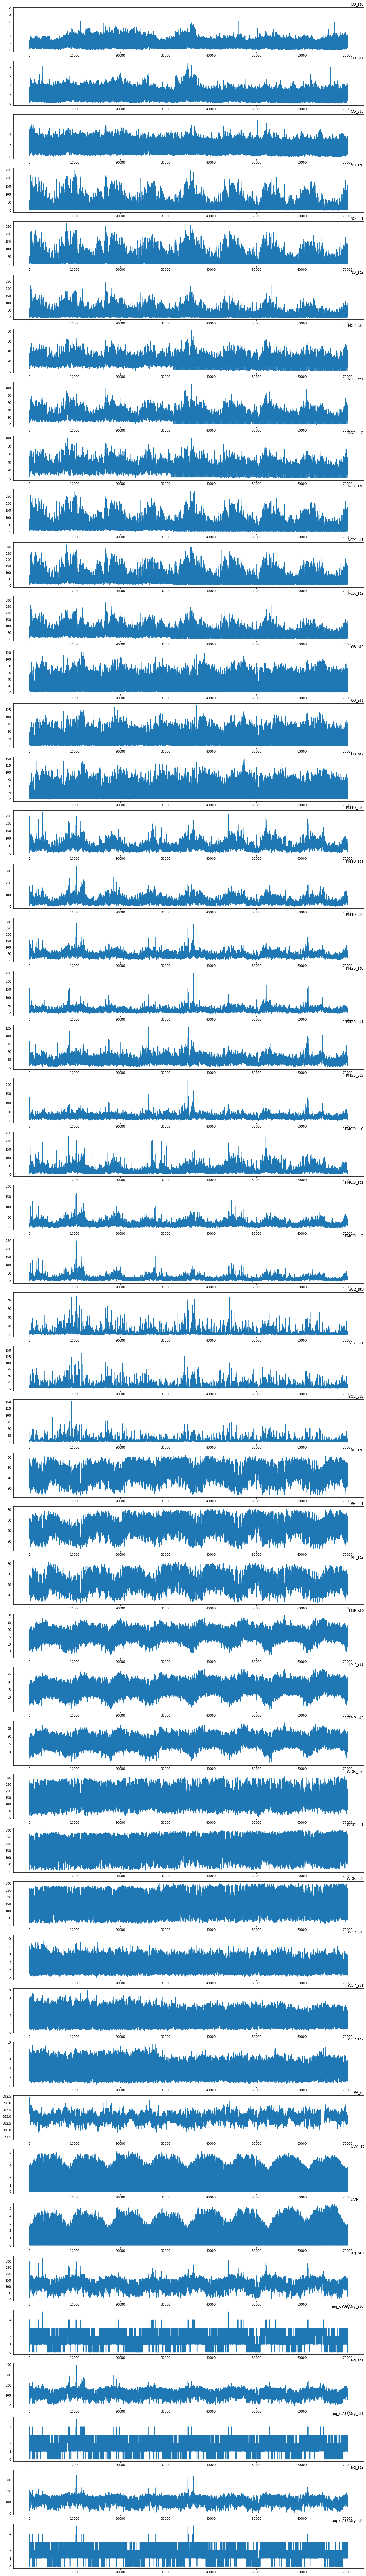

In [22]:
groups = create_list_range (3,len(df_workspace.columns),1)
plot_dataframe(df_workspace, df_workspace.values, groups, 1)

In [327]:
#features without pm2.5 and pm10
columns_station_0 = ['PA_st', 'UVA_st', 'UVB_st', 'CO_st0','NO_st0', 'NO2_st0', 'NOX_st0',
                     'O3_st0', 'PMCO_st0','SO2_st0','RH_st0','TMP_st0',
                     'WDR_st0','WSP_st0']

columns_station_1 = ['PA_st', 'UVA_st', 'UVB_st', 'CO_st1','NO_st1', 'NO2_st1', 'NOX_st1',
                     'O3_st1', 'PMCO_st1','SO2_st1','RH_st1','TMP_st1',
                     'WDR_st1','WSP_st1']

columns_station_2 = ['PA_st', 'UVA_st', 'UVB_st', 'CO_st2','NO_st2', 'NO2_st2', 'NOX_st2',
                     'O3_st2', 'PMCO_st2','SO2_st2','RH_st2','TMP_st2',
                     'WDR_st2','WSP_st2']

## PCA to check feature behavior along dataset

In [328]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA

def perform_pca(df, column_names, number_of_components):    
    # normalize data
    data_scaled = pd.DataFrame(preprocessing.scale(df[column_names]),columns = column_names) 
    # PCA
    pca = PCA(n_components = number_of_components)
    pca.fit_transform(data_scaled)
    # number of components
    n_pcs= pca.components_.shape[0]

    # get the index of the most important feature on EACH component i.e. largest absolute value
    # using LIST COMPREHENSION HERE
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

    # get the names
    most_important_names = [column_names[most_important[i]] for i in range(n_pcs)]

    # using LIST COMPREHENSION HERE AGAIN
    dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
    # build the dataframe
    result_df = pd.DataFrame(sorted(dic.items()))
    result_df['Ratio'] = pca.explained_variance_ratio_
    result_df.columns = ['PC', 'Feature' , 'Ratio']
    return result_df


## Get 5 most important influence on the principal component by its ratio

In [329]:
perform_pca(df_workspace,columns_station_0,5)

PC   Feature     Ratio
0  PC1    O3_st0  0.350153
1  PC2  PMCO_st0  0.180901
2  PC3    UVB_st  0.132297
3  PC4   WDR_st0  0.081519
4  PC5   WDR_st0  0.062139

In [330]:
perform_pca(df_workspace,columns_station_1,5)

PC   Feature     Ratio
0  PC1   TMP_st1  0.331125
1  PC2  PMCO_st1  0.210436
2  PC3   WSP_st1  0.134615
3  PC4   SO2_st1  0.084315
4  PC5     PA_st  0.064824

In [331]:
perform_pca(df_workspace,columns_station_2,5)

PC  Feature     Ratio
0  PC1   O3_st2  0.312896
1  PC2  NOX_st2  0.212900
2  PC3  WSP_st2  0.144938
3  PC4    PA_st  0.082087
4  PC5  SO2_st2  0.065211

## Train and test datasets to compute aiq without using pm2.5 and pm10 as classification problem

In [332]:
#split dataset
from sklearn.model_selection import train_test_split

def get_train_test(df, features, classification_feature  , test_size_, random_state_):
    X_train, X_test, y_train, y_test = train_test_split(
        df[features], 
        df[classification_feature], 
        test_size=test_size_, 
        random_state=random_state_)
    return [X_train, X_test, y_train, y_test]

In [333]:
X_train_st0, X_test_st0, y_train_st0, y_test_st0 = get_train_test(
    df_workspace, columns_station_0, ['aiq_category_st0'], 0.2, 7)

X_train_st1, X_test_st1, y_train_st1, y_test_st1 = get_train_test(
    df_workspace, columns_station_1, ['aiq_category_st1'], 0.2, 7)


X_train_st2, X_test_st2, y_train_st2, y_test_st2 = get_train_test(
    df_workspace, columns_station_2, ['aiq_category_st2'], 0.2, 7)

In [334]:
def build_confusion_matrix(predicted, true, labels_):
    cm_st = confusion_matrix(predicted, true)
    sns.heatmap(cm_st0, annot=True, fmt=".0f", linewidths=.5, 
                square = True, cmap = 'Blues_r',
                xticklabels=labels_,
                yticklabels=labels_)
    plt.xlabel('True')
    plt.ylabel('predicted')

# Logistic regression

In [335]:
aqi_labels= ['Good','Moderate','sg', 'Unhealthy','Very Unhealthy','Hazardous']

def apply_logistic_regression(X_tr,y_tr, x_te, y_te, random_state_):
    logreg = LogisticRegression(random_state=random_state_)
    logreg.fit(X_tr,y_tr)
    y_pred   = logreg.predict(x_te)
    accuracy = accuracy_score(y_te, y_pred)
    print("Accuracy score: ", accuracy)
    build_confusion_matrix(y_te,y_pred,aqi_labels)
    return [accuracy,y_pred]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy score:  0.7390646393312675


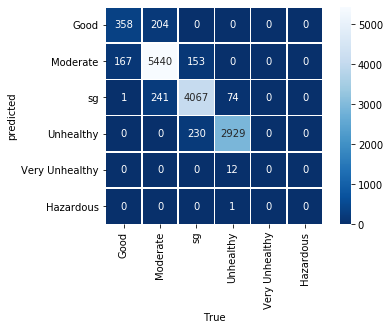

In [336]:
#perform logistic regression
[accuracy_st0,y_pred_st0] = apply_logistic_regression(
    X_train_st0, y_train_st0, X_test_st0, y_test_st0, 7 )


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy score:  0.7390646393312675


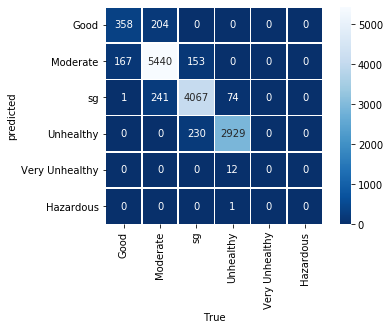

In [337]:
[accuracy_st0,y_pred_st0] = apply_logistic_regression(
    X_train_st0, y_train_st0, X_test_st0, y_test_st0, 7 )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy score:  0.781148663255747


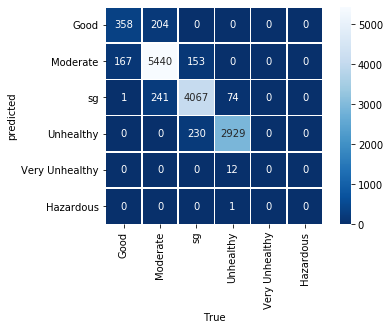

In [338]:
[accuracy_st2,y_pred_st2] = apply_logistic_regression(
    X_train_st2, y_train_st2, X_test_st2, y_test_st2, 7 )

# Naive Bayes

In [339]:
aqi_labels= ['Good','Moderate','sg', 'Unhealthy','Very Unhealthy','Hazardous']

def apply_naive_bayes(X_tr,y_tr, x_te, y_te):
    naive_bayes = GaussianNB()
    naive_bayes.fit(X_tr,y_tr)
    y_pred   = naive_bayes.predict(x_te)
    accuracy = accuracy_score(y_te, y_pred)
    print("Accuracy score: ", accuracy)
    build_confusion_matrix(y_te,y_pred,aqi_labels)
    return [accuracy,y_pred]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score:  0.6317647906608056


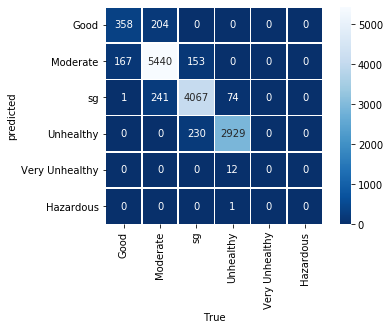

In [340]:
#perform naive bayes
[accuracy_nb_st0,y_pred_nb_st0] = apply_naive_bayes(
    X_train_st0, y_train_st0, X_test_st0, y_test_st0 )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score:  0.635295813216113


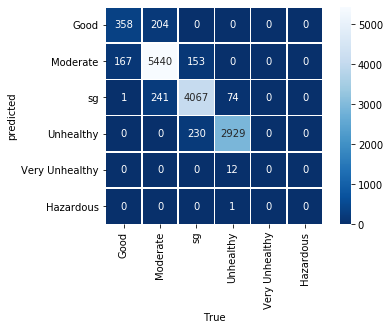

In [341]:
[accuracy_nb_st1,y_pred_nb_st1] = apply_naive_bayes(
    X_train_st1, y_train_st1, X_test_st1, y_test_st1 )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score:  0.665922029257044


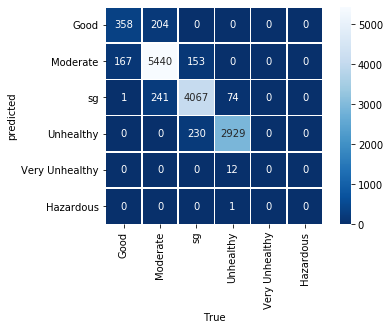

In [342]:
[accuracy_nb_st2,y_pred_nb_st2] = apply_naive_bayes(
    X_train_st2, y_train_st2, X_test_st2, y_test_st2 )

## Decision Tree 

In [343]:
aqi_labels= ['Good','Moderate','sg', 'Unhealthy','Very Unhealthy','Hazardous']
import pydotplus
from IPython.display import Image, display
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

def show_tree(tree_):
    dot_data = StringIO()
    export_graphviz(tree_, 
                    out_file=dot_data, 
                    filled=True, 
                    rounded= True, 
                    special_characters=True )
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    Image(graph.create_png())

def apply_decision_tree(X_tr,y_tr, x_te, y_te):
    decision_tree = tree.DecisionTreeClassifier()
    decision_tree.fit(X_tr,y_tr)
    y_pred   = decision_tree.predict(x_te)
    accuracy = accuracy_score(y_te, y_pred)
    print("Accuracy score: ", accuracy)
    #show_tree(decision_tree)
    build_confusion_matrix(y_te,y_pred,aqi_labels)
    return [accuracy,y_pred]

Accuracy score:  0.6909994955682064


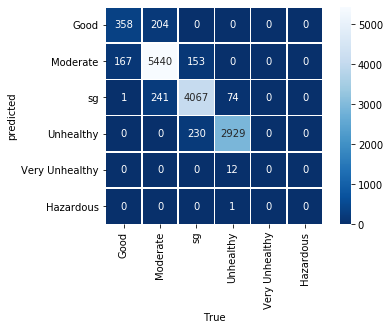

In [344]:
#perform decision tree
[accuracy_dt_st0,y_pred_dt_st0] = apply_decision_tree(
    X_train_st0, y_train_st0, X_test_st0, y_test_st0 )



Accuracy score:  0.6891258917633494


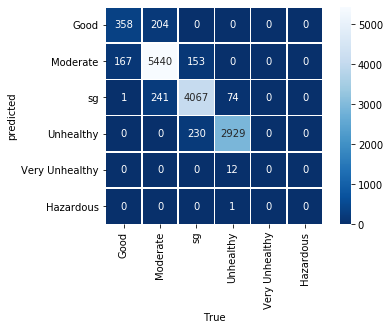

In [345]:
[accuracy_dt_st1,y_pred_dt_st1] = apply_decision_tree(
    X_train_st1, y_train_st1, X_test_st1, y_test_st1 )

Accuracy score:  0.7580168624342437


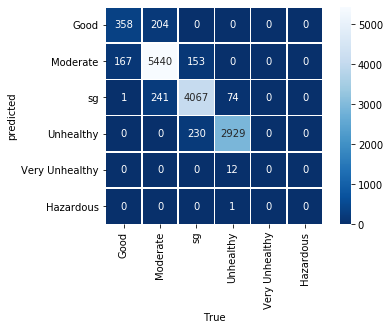

In [346]:
[accuracy_dt_st2,y_pred_dt_st2] = apply_decision_tree(
    X_train_st2, y_train_st2, X_test_st2, y_test_st2 )

# Random Forest

In [347]:
def apply_random_forest(X_tr,y_tr, x_te, y_te, number_estimators):
    random_forest_model = RandomForestClassifier(n_estimators=number_estimators)
    random_forest_model.fit(X_tr,y_tr)
    y_pred   = random_forest_model.predict(x_te)
    
    n_nodes = []
    max_depths = []
    
    for ind_tree in random_forest_model.estimators_:
        n_nodes.append(ind_tree.tree_.node_count)
        max_depths.append(ind_tree.tree_.max_depth)
    accuracy = accuracy_score(y_te, y_pred)
    print("Average number of nodes: ", ( int(np.mean(n_nodes))   ))
    print("Average maximum lenght: ", ( int(np.mean(max_depths))   ))
    print("Accuracy score: ", accuracy)
    build_confusion_matrix(y_te,y_pred,aqi_labels)
    return [accuracy,y_pred]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Average number of nodes:  16151
Average maximum lenght:  33
Accuracy score:  0.7858326727678893


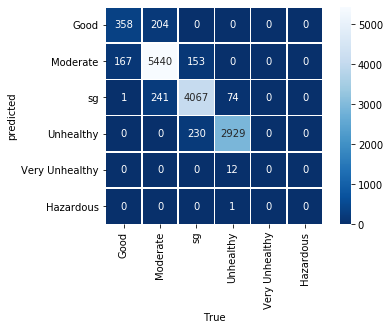

In [348]:
#perform random forest
[accuracy_rf_st0,y_pred_rf_st0] = apply_random_forest(
    X_train_st0, y_train_st0, X_test_st0, y_test_st0 , 100)



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Average number of nodes:  16214
Average maximum lenght:  32
Accuracy score:  0.7841031923326367


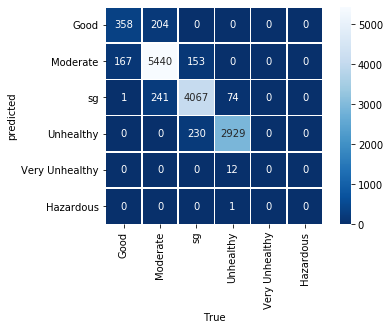

In [349]:
[accuracy_rf_st1,y_pred_rf_st1] = apply_random_forest(
    X_train_st1, y_train_st1, X_test_st1, y_test_st1 , 100)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Average number of nodes:  13787
Average maximum lenght:  31
Accuracy score:  0.8386538877278951


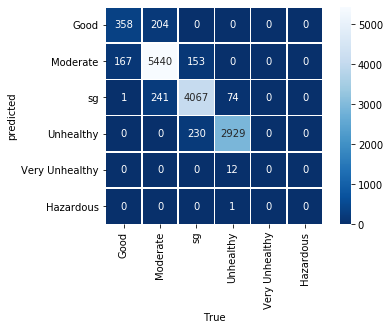

In [350]:
[accuracy_rf_st2,y_pred_rf_st2] = apply_random_forest(
    X_train_st2, y_train_st2, X_test_st2, y_test_st2 , 100)

**Random forest** is useful to predict air category based on several features, if **pm2.5 and pm10 are missing**

# Forecasting

In [23]:
#Add day of the week to df_workspace
df_workspace['Day'] = pd.DatetimeIndex(df_workspace['date']).day_name() # week day name
df_workspace['Day'] = pd.Categorical(df_workspace['Day'])
df_workspace['Day'] = df_workspace['Day'].cat.codes

In [24]:
df_workspace.tail(5)

date       fecha  hora  CO_st0  CO_st1  CO_st2  NO_st0  \
70123 2019-12-31 19:00:00  2019-12-31    19  2.9875  2.8875  2.6500   5.375   
70124 2019-12-31 20:00:00  2019-12-31    20  3.0500  3.2250  2.8875   6.750   
70125 2019-12-31 21:00:00  2019-12-31    21  3.1750  3.4125  3.3750   6.625   
70126 2019-12-31 22:00:00  2019-12-31    22  3.4875  3.6875  3.5625   8.375   
70127 2019-12-31 23:00:00  2019-12-31    23  3.6750  3.8125  3.6250   8.875   

       NO_st1  NO_st2  NO2_st0  ...    PA_st  UVA_st  UVB_st  aiq_st0  \
70123  10.000   5.125     27.8  ...  583.667     0.0     0.0    157.0   
70124  18.000   5.375     25.1  ...  584.317     0.0     0.0    159.0   
70125  18.625  10.625     26.3  ...  584.700     0.0     0.0    153.0   
70126  24.375  12.125     31.2  ...  584.833     0.0     0.0    163.0   
70127  23.500   9.750     31.6  ...  584.867     0.0     0.0    170.0   

       aiq_category_st0  aiq_st1  aiq_category_st1  aiq_st2  aiq_category_st2  \
70123                 3    153.0                 3     79.0                 1   
70124                 3    164.0                 3     87.0                 1   
70125                 3    155.0                 3    121.0                 2   
70126                 3    159.0                 3    125.0                 2   
70127                 3    164.0                 3    152.0                 3   

       Day  
70123    5  
70124    5  
70125    5  
70126    5  
70127    5  

[5 rows x 52 columns]

In [25]:
# set date as index
df_workspace.set_index('date', inplace=True)

In [26]:
def plot_resample_date(df,start_date,end_date, cols, resample_by):
    df[start_date:end_date][cols].resample(resample_by).mean().plot(figsize=(15, 6))
    plt.show()

    


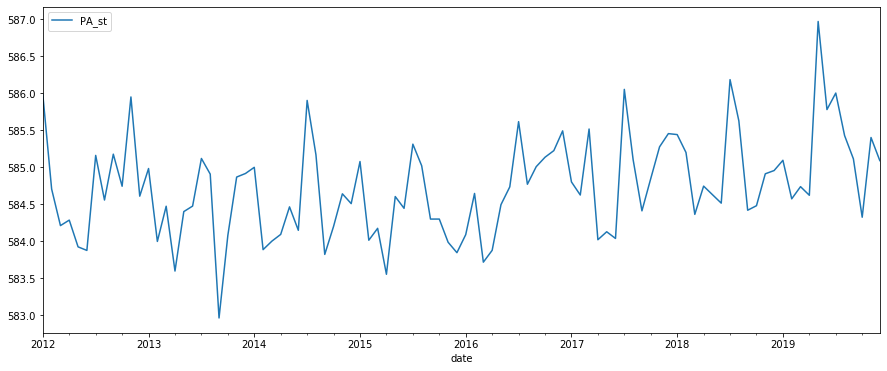

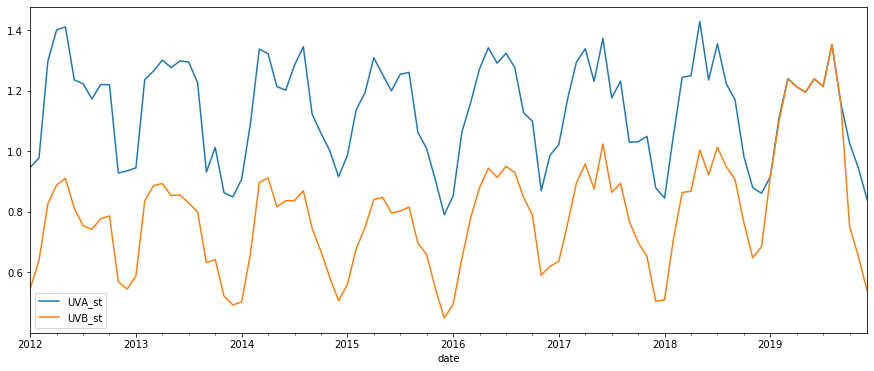

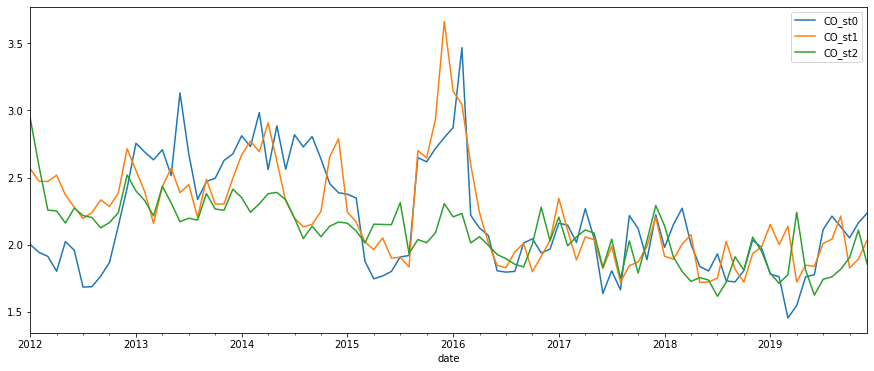

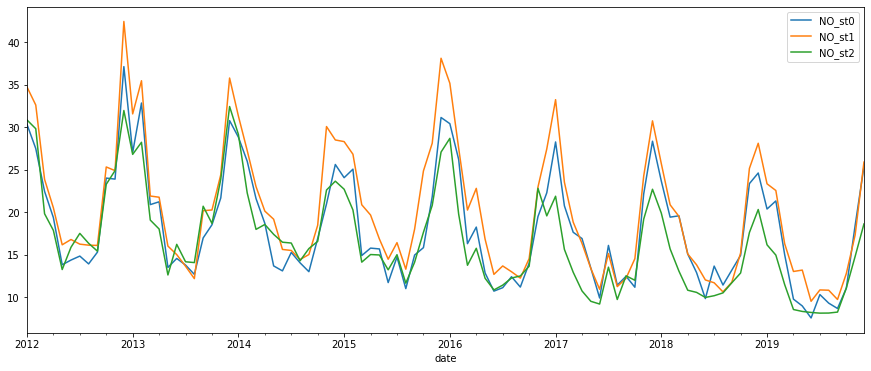

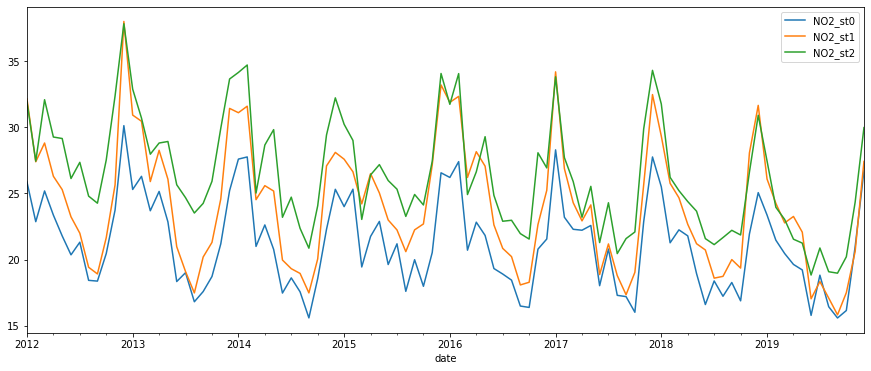

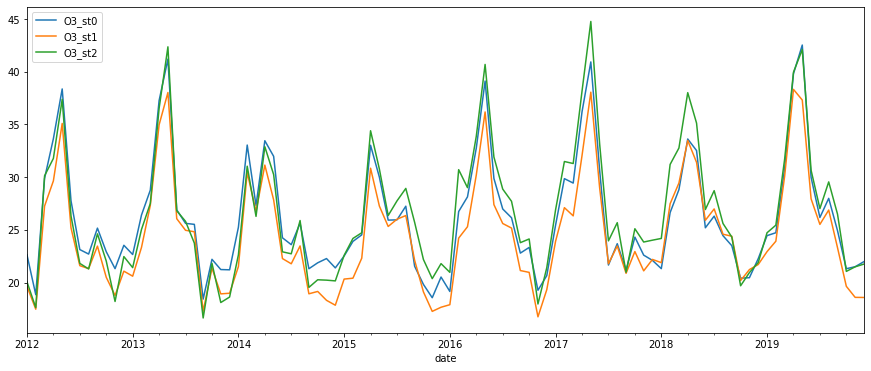

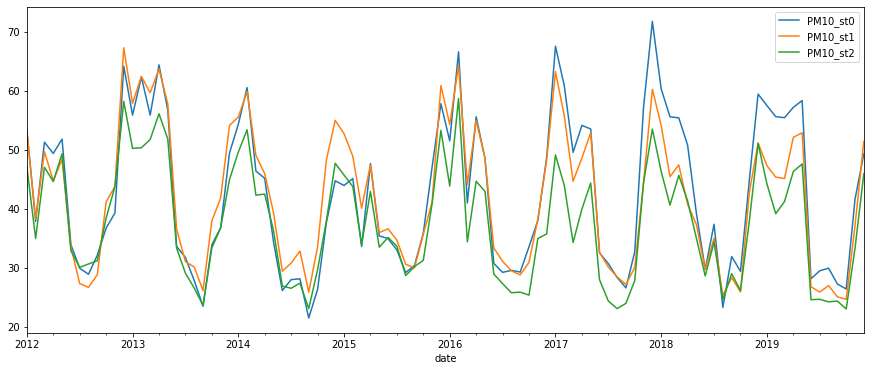

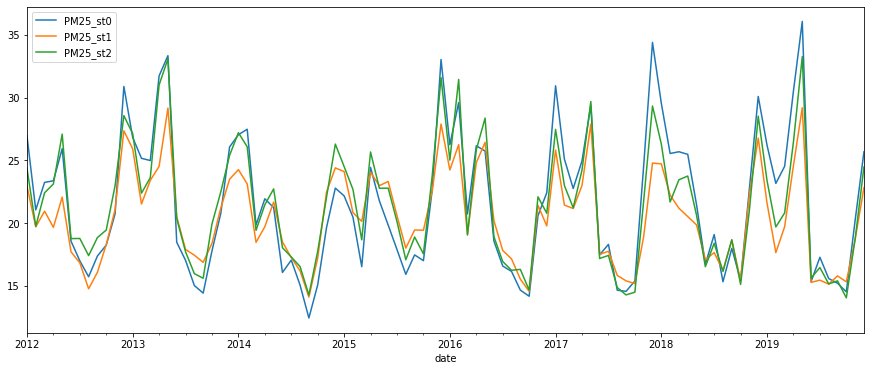

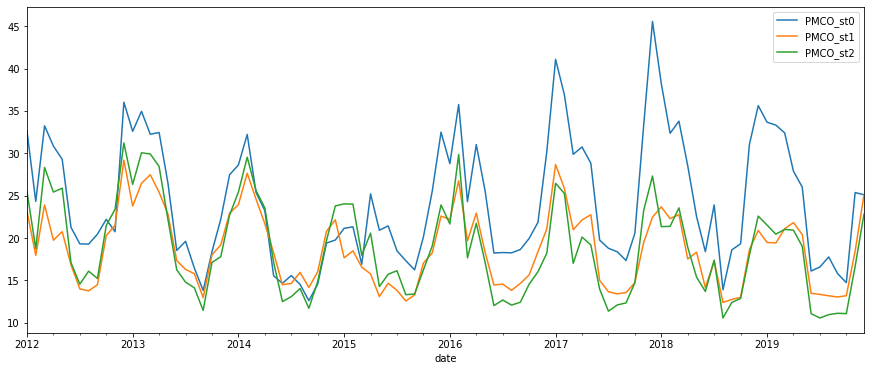

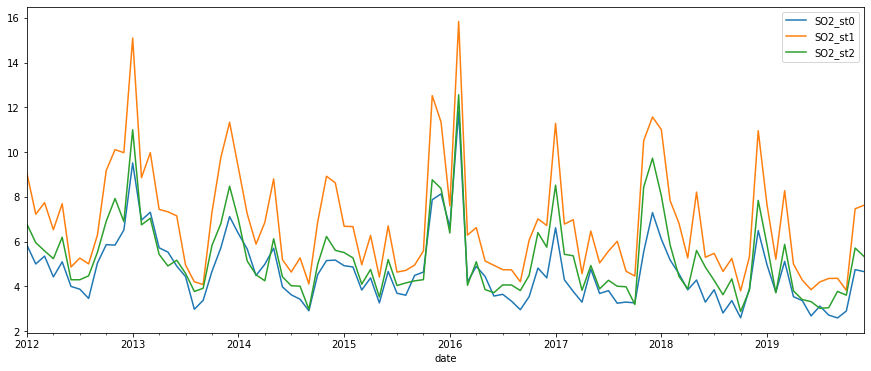

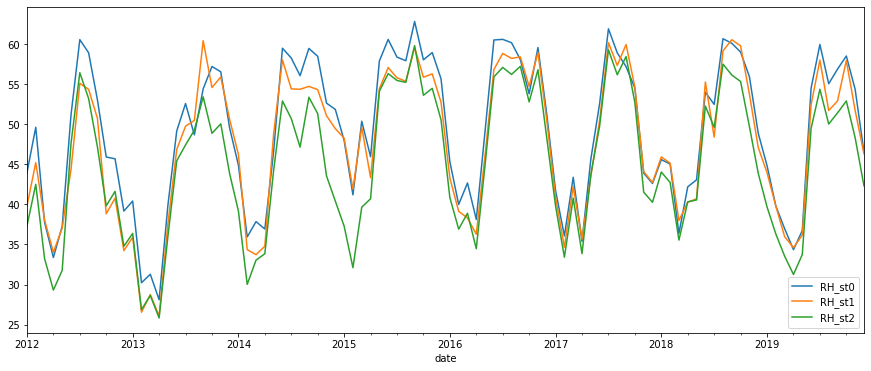

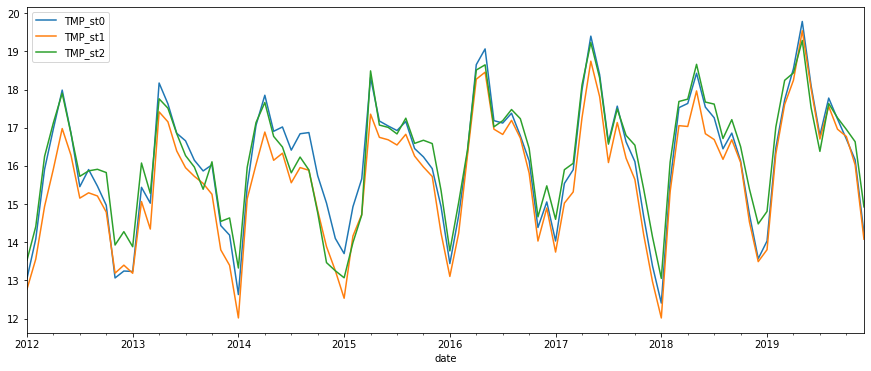

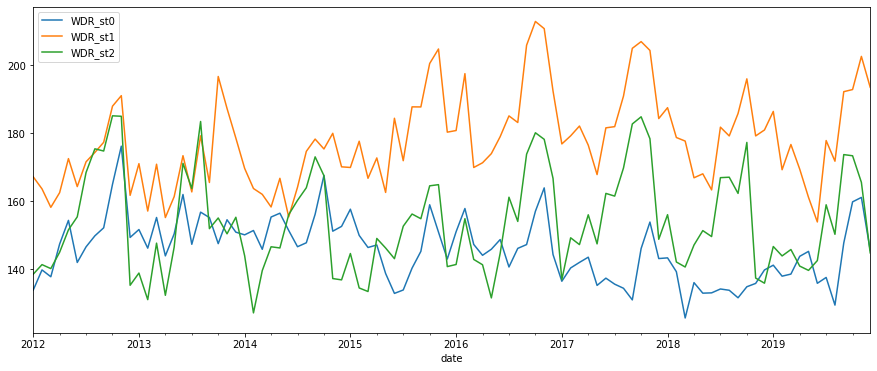

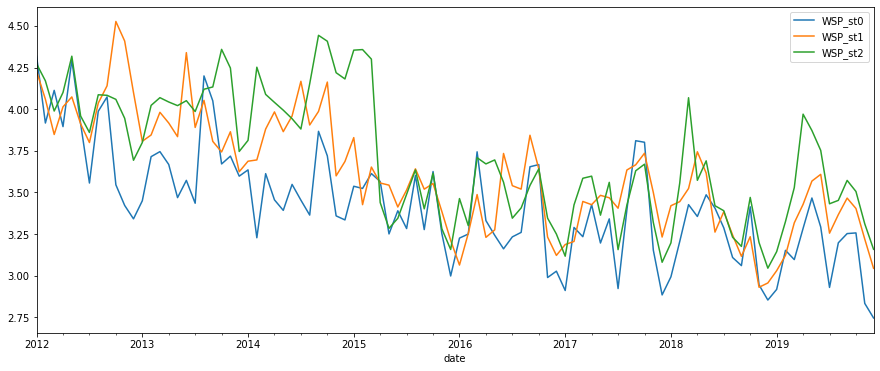

In [27]:
resample_by = 'MS'#'24H'
#for year in range(2012,2019):
#    print("SAMPLE BY 24 HRS BY YEAR: ", year)
year =2012
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'PA_st'], resample_by )
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'UVA_st','UVB_st'], resample_by)
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'CO_st0','CO_st1', 'CO_st2'], resample_by)
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'NO_st0', 'NO_st1', 'NO_st2'], resample_by)
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'NO2_st0', 'NO2_st1','NO2_st2'], resample_by)
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'O3_st0', 'O3_st1','O3_st2'], resample_by)
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'PM10_st0', 'PM10_st1', 'PM10_st2'], resample_by)
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'PM25_st0', 'PM25_st1', 'PM25_st2'], resample_by)
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'PMCO_st0', 'PMCO_st1', 'PMCO_st2'], resample_by)
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'SO2_st0', 'SO2_st1','SO2_st2'], resample_by)
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'RH_st0', 'RH_st1', 'RH_st2'], resample_by)
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'TMP_st0', 'TMP_st1','TMP_st2'], resample_by)
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'WDR_st0', 'WDR_st1', 'WDR_st2'], resample_by)
plot_resample_date(df_workspace,str(year),str(year+7) ,[ 'WSP_st0', 'WSP_st1', 'WSP_st2'], resample_by)


## Check for seasonality

In [535]:
'''from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
def plotseasonal( data ):
    res = sm.tsa.seasonal_decompose(data)
    res.plot()
    plt.show()'''
    

'from plotly.plotly import plot_mpl\nfrom statsmodels.tsa.seasonal import seasonal_decompose\ndef plotseasonal( data ):\n    res = sm.tsa.seasonal_decompose(data)\n    res.plot()\n    plt.show()'

# Baseline model

## Forecasting with ARIMA

Time series provide the opportunity to forecast future values. Based on previous values, time series can be used to forecast trends in economics, weather, and capacity planning, to name a few. The specific properties of time-series data mean that specialized statistical methods are usually required. In this case pollution features will be predicted.

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

 - p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
 - d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
 - q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
 
When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.


## Parameter Selection for the ARIMA Time Series Model

In [424]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

def grid_search_arima_parameters(data):
    '''iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit 
    the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the
    seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. 
    After fitting each SARIMAX()model, the code returns dataframe with its respective AIC score.
    '''       
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    #print(seasonal_pdq)
    #warnings.filterwarnings("ignore") # specify to ignore warning messages

    df_aic = pd.DataFrame(columns=['aic', 'param', 'seasonal_param'])
    i = 0
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()

                df_aic.loc[i] = [results.aic, param, param_seasonal]
                i+=1
            except:
                continue

    return df_aic.sort_values(by='aic', ascending=1)
    

The first row yields the lowest AIC value that sill be used.

## Fitting an ARIMA Time Series Model

In [364]:
def fit_arima(data):
    #get parameters    
    parameters_to_use = grid_search_arima_parameters(data).head(1)
    #fit model    
    best_order = parameters_to_use['param'].iloc[0]
    best_seasonal_order = parameters_to_use['seasonal_param'].iloc[0]
    mod = sm.tsa.statespace.SARIMAX(data,
                                    
                                order         =  best_order,
                                seasonal_order=  best_seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    return mod.fit()


def plot_arima_diagnostics(results):
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    


    
def plot_arima_forecast(data, arima_result, start_date, start_forecasting_date, start_future, ylabel, step_to_predict_future=72):
    
    #truth data
    ax = data[start_date:].plot(figsize=[15, 8], label='True')
    
    #future 
    dtf = arima_future(arima_result, start_future, step_to_predict_future) 
    dtf.plot(figsize=[15, 8], ax=ax, color='green', label='Future')
    
    
    #prediction using model with known data
    pred = arima_result.get_prediction(start=pd.to_datetime(start_forecasting_date), dynamic=True)
    pred_ci = pred.conf_int()
    pred.predicted_mean.plot(figsize=[15, 8], ax=ax, label='Forecast', alpha=.7)
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    plt.legend()
    plt.show()   
    
    data_forecasted = pred.predicted_mean
    data_truth = data[start_forecasting_date:]
    # Compute the mean square error
    rmse = (((data_forecasted - data_truth) ** 2).mean()) ** 0.5
    print('The Root Mean Squared Error of prediction is {}'.format(round(rmse, 2)))
    
    
def arima_future(arima_result_, start_future, step_to_predict_future):
    #future
    foret = arima_result_.forecast(step_to_predict_future)
    dtf = pd.DataFrame (foret, columns = ['Future'])
    dtf['date'] = pd.date_range(start=start_future, freq='1H', periods=len(foret))
    dtf.set_index('date', inplace=True)
    return dtf
    

In [646]:
#results = fit_arima(df_workspace['NO_st0']) #.resample('24H').mean()
#results.save('model_NO.pkl')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7707      0.001    626.967      0.000       0.768       0.773
ma.L1          0.3612      0.002    186.566      0.000       0.357       0.365
ar.S.L12      -0.4115      0.003   -157.962      0.000      -0.417      -0.406
ma.S.L12      -0.9237      0.001  -1002.152      0.000      -0.926      -0.922
sigma2        82.4798      0.175    472.556      0.000      82.138      82.822


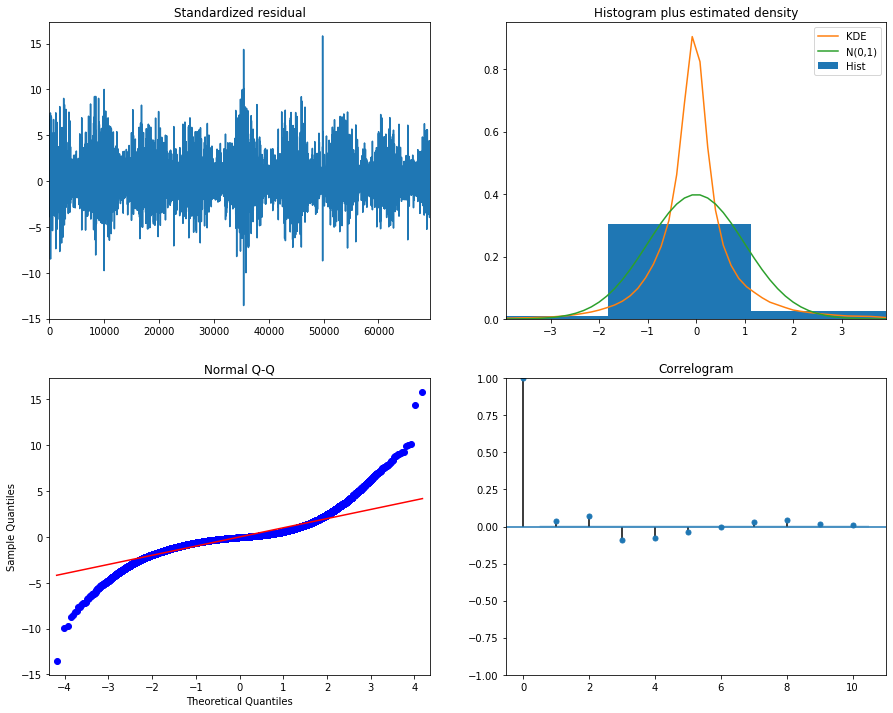

In [645]:
print(results.summary().tables[1])
plot_arima_diagnostics(results)

In [1]:

from statsmodels.tsa.arima_model import ARIMAResults
#loaded_SO2 = ARIMAResults.load('model_NO.pkl')
#plot_arima_forecast(df_workspace['NO_st0'],loaded_SO2,'2019-12-20 11:00:00','2019-12-28 11:00:00','2019-12-31 23:00:00','NO2', 72)

In [ ]:
#learning-curves
#https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

In [557]:
!pip install missingno

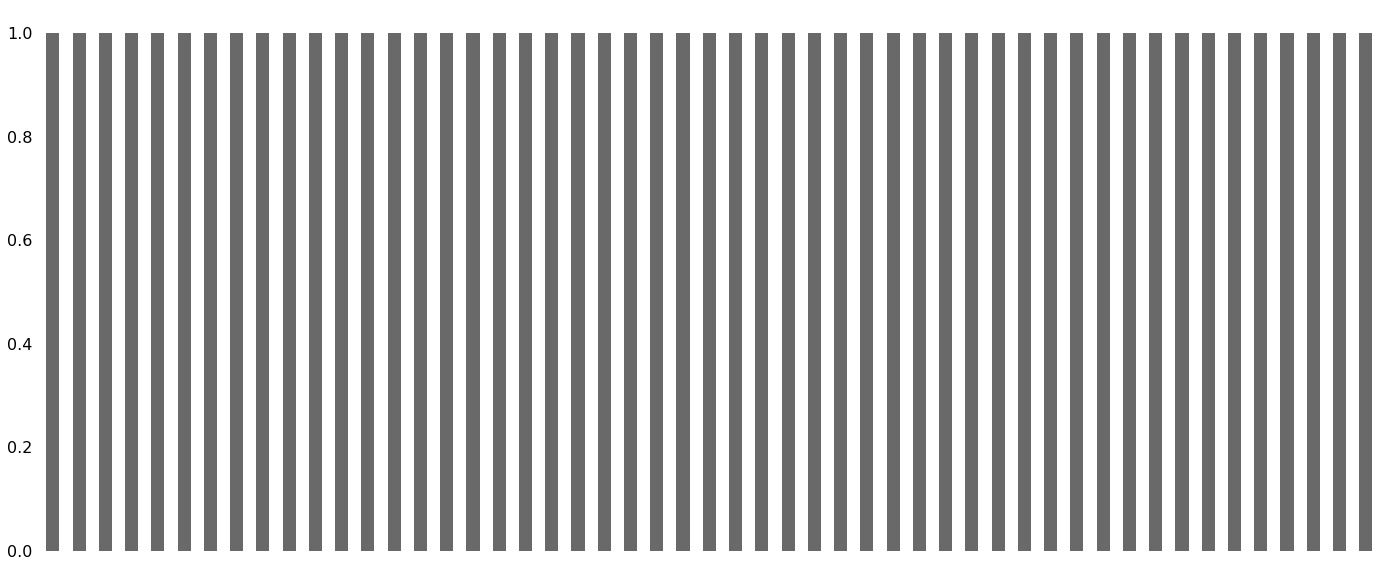

In [564]:
import missingno as msno 
#msno.matrix(df_workspace)  
msno.bar(df_workspace) 

In [733]:
'''arima_columns = ['RH_st0','TMP_st0'] #'UVA_st', 'UVB_st','CO_st0','NO2_st0','NOX_st0','O3_st0','PMCO_st0','SO2_st0',
#repeat for all columns
for column in arima_columns: 
    results = fit_arima(df_workspace[column]) #.resample('24H').mean()
    results.save('model_'+column+'.pkl')
'''

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency i

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likel

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date inde

OSError: [Errno 28] No space left on device

In [764]:
results.forecast?

Notes:

 - Accuracy summarizes correct predictions for class labels. It cannot be used for regression. Instead you must calculate an error metric, like RMSE.
 
 - The activation function of the output (Y variable) layer  is ‘linear’, the default. This must be the case because we are predicting a real-value.
 
 - Batch size is the number of samples (e.g. sequences) to that are used to estimate the gradient before the weights are updated. The internal state is reset at the end of each batch after the weights are updated.   One sample is comprised of 1 or more time steps that are stepped over during backpropagation through time. Each time step may have one or more features (e.g. observations recorded at that time).

 - Time steps and batch size and generally not related. You can split up a sequence to have one-time step per sequence. In that case you will not get the benefit of learning across time (e.g. bptt), but you can reset state at the end of the time steps for one sequence. This an odd config though and really only good to showing off the LSTMs memory capability.
 

# Univariate LSTM

In [104]:
from numpy import array

def get_train_test_univariate(df, column_name, training_hours):
    x___train = df[column_name][:training_hours]
    x___test  = df[column_name][training_hours :]
    print ("Using {}% of data to train".format(training_hours / df.shape[0] * 100))
    return [x___train,x___test]
    

def normalize_univariate(to_normalize):
    #converted into array as all the methods available are for arrays and not lists
    norm_arr = np.asarray(to_normalize)
    norm = np.reshape(norm_arr, (-1, 1))
    #Scaling all values between 0 and 1 so that large values don't just dominate
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(norm)


def split_sequence(sequence, n_steps):
    '''
    Since this is a time series data, we should be predicting the values after looking at a 
    set of values rather than just a single value like we usually do. 
    This takes into account the correlation between the data points and the timestamps. 
    Because the neighbours should be considered for how the values change over time. 
    
    This splits the sequence into sets of n values. 
    n is given as n_steps or step size. 
    if n=3, we split the sequence in groups of 3. 
    We create 2 empty lists and append the split sequences.
    '''
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y) 

def get_split_data_lstm(df, column_name, days_to_train, n_steps):
    #train and test
    [x_train,x_test] = get_train_test_univariate(df, column_name, days_to_train*24)
    #normalize
    train_norm       = normalize_univariate(x_train)
    test_norm        = normalize_univariate(x_test)
    #split in steps, number of features = 1
    X_split_train, y_split_train = split_sequence(train_norm, n_steps)
    X_split_train    = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], 1))
    X_split_test, y_split_test = split_sequence(test_norm, n_steps)
    X_split_test     = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], 1))
    return [X_split_train, y_split_train, X_split_test, y_split_test]

def define_univariate_lstm(n_neurons, n_steps, n_features):
    # define model
    model = Sequential()
    model.add(LSTM(  n_neurons, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(100, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model


def tune_lstm(feature, 
              n_steps, 
              neurons, 
              epochs, 
              batches, 
              X_split_train, 
              y_split_train,
              X_split_test,
              y_split_test,
              n_experiments = 3) :  
    results=[]    
    for i in range(0, n_experiments):
        for n in neurons:
            for e in epochs:
                for b in batches:
                    # run diagnostic tests
                    model = define_univariate_lstm(n, n_steps, 1)
                    history = model.fit(
                                X_split_train, 
                                y_split_train, 
                                validation_data=(X_split_test, y_split_test), 
                                epochs    = e,  
                                batch_size= b, 
                                verbose   = 0)
                    yhat = model.predict(X_split_test)
                    mse  = mean_squared_error(y_split_test, yhat)
                    
                    results.append([i, n, e , b , mse])
                    #plot for info 
                    print("i: {}, Neurons: {}, epoch: {}, batch: {}, mse: {}".format(i, n, e , b , mse))
                    lst_str = [str(n), str(e), str(b), str(mse)]
                    str_concat = " ".join(lst_str)                   
                    #reset
                    model.reset_states()
                    
    df_result = pd.DataFrame(rrresults,columns=['i','n','e','b','mse'])
    return df_result.groupby(
        [ df_result['n'], df_result['e'], df_result['b']  ] ).mean().sort_values(
        by=['mse'],ascending=True)
        
    

In [ ]:
'''#toy example test case to check 
days_to_train = 2557 # days
n_steps       = 72   # hours
n_experiments = 2
n_epochs  = [1,2,3]#[16,32,64]
n_neurons = [50,100]
n_batch   = [24,48,72]

[X_s_train,y_s_train, X_s_test, y_s_test] =  get_split_data_lstm(
    df_workspace, 'NO2_st0', days_to_train, n_steps)
testcase_df = tune_lstm('NO2_st0', 
                        n_steps, 
                        n_neurons, 
                        n_epochs, 
                        n_batch,                          
                        X_s_train,
                        y_s_train, 
                        X_s_test, 
                        y_s_test,
                       n_experiments)
testcase_df
'''

In [132]:
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas import Series

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    #initializing the neural network
    model = Sequential()
    #Long Short-Term Memory layer
    model.add(LSTM(
        neurons, 
        batch_input_shape = (batch_size, X.shape[1], X.shape[2]), 
        stateful=True)
             )
    #Dense is a layer type (fully connected layer)
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    #for i in range(nb_epoch):
    #    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    #    model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 




In [210]:
# load dataset
days_to_train  = 2557
training_hours = days_to_train*24
# transform data to be stationary
raw_values = df_workspace['NO2_st0'].values
diff_values = difference(raw_values, 1)
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
# split data into train start:training_hours and test training_hours:end  sets
train, test = supervised_values[:training_hours], supervised_values[training_hours:]
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
# fit the model
print("number of hours for training {}".format(len(train_scaled)))
# fit the model

# 1 batch size
'''
Online Learning (Batch Size = 1 hour),network weights are updated after each training example 
This can have the effect of faster learning, but also adds instability to the learning process as the weights
widely vary with each batch.
Nevertheless, this will allow us to make one-step forecasts on the problem, that is what we want.

however other option is to try bacth size of 72 that is, the time we want the weights to be updated
and the time we want to predict
'''

# 30 epochs
#  4 neurons
lstm_model = fit_lstm(train_scaled, 1, 30, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

61368


array([[ 0.20641004],
       [ 0.18542227],
       [ 0.08664913],
       ...,
       [-0.02670754],
       [ 0.02228341],
       [-0.04412673]], dtype=float32)

In [211]:
len(train_scaled)

61368

In [257]:
import numpy
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1, Predicted=11.202449, Expected=19.441000
2, Predicted=5.154805, Expected=2.000000
3, Predicted=-6.646429, Expected=26.500000
4, Predicted=10.070358, Expected=23.700000
5, Predicted=18.175263, Expected=22.100000
6, Predicted=8.314480, Expected=20.300000
7, Predicted=12.769130, Expected=18.700000
8, Predicted=7.961940, Expected=26.500000
9, Predicted=18.675896, Expected=30.400000
10, Predicted=22.658008, Expected=22.900000
11, Predicted=14.636089, Expected=14.300000
12, Predicted=5.986012, Expected=11.000000
13, Predicted=4.546839, Expected=9.700000
14, Predicted=4.657229, Expected=10.400000
15, Predicted=6.962768, Expected=10.200000
16, Predicted=7.119853, Expected=9.900000
17, Predicted=7.299084, Expected=12.300000
18, Predicted=11.408035, Expected=17.900000
19, Predicted=18.078211, Expected=26.000000
20, Predicted=25.935867, Expected=32.100000
21, Predicted=31.063570, Expected=32.800000
22, Predicted=30.376365, Expected=34.400000
23, Predicted=32.681953, Expected=30.700000
24, Predi

212, Predicted=16.909529, Expected=22.250000
213, Predicted=21.484888, Expected=20.500000
214, Predicted=18.343218, Expected=17.100000
215, Predicted=14.218905, Expected=16.700000
216, Predicted=15.851846, Expected=13.500000
217, Predicted=11.509841, Expected=12.100000
218, Predicted=11.200796, Expected=12.400000
219, Predicted=13.419727, Expected=11.800000
220, Predicted=12.518961, Expected=12.000000
221, Predicted=13.391399, Expected=18.300000
222, Predicted=23.491781, Expected=20.900000
223, Predicted=22.364060, Expected=23.000000
224, Predicted=24.496880, Expected=22.500000
225, Predicted=21.094554, Expected=17.300000
226, Predicted=12.848233, Expected=14.200000
227, Predicted=11.215937, Expected=16.500000
228, Predicted=17.855123, Expected=14.800000
229, Predicted=13.616297, Expected=12.500000
230, Predicted=10.818713, Expected=12.100000
231, Predicted=11.900493, Expected=11.500000
232, Predicted=11.652125, Expected=13.900000
233, Predicted=16.857110, Expected=16.300000
234, Predi

397, Predicted=16.691928, Expected=19.100000
398, Predicted=16.909311, Expected=14.700000
399, Predicted=11.957294, Expected=14.300000
400, Predicted=13.828777, Expected=15.100000
401, Predicted=16.703433, Expected=19.100000
402, Predicted=23.115503, Expected=22.600000
403, Predicted=25.070827, Expected=26.300000
404, Predicted=28.544060, Expected=27.900000
405, Predicted=28.208839, Expected=29.100000
406, Predicted=29.211006, Expected=29.800000
407, Predicted=29.316036, Expected=28.900000
408, Predicted=27.257270, Expected=23.200000
409, Predicted=19.155666, Expected=24.400000
410, Predicted=24.442054, Expected=22.900000
411, Predicted=21.814376, Expected=21.900000
412, Predicted=21.238245, Expected=21.200000
413, Predicted=21.051269, Expected=21.000000
414, Predicted=21.529461, Expected=21.950000
415, Predicted=23.699796, Expected=24.200000
416, Predicted=26.941716, Expected=27.100000
417, Predicted=29.759757, Expected=25.105300
418, Predicted=23.476903, Expected=22.924500
419, Predi

605, Predicted=23.548670, Expected=25.000000
606, Predicted=27.542961, Expected=26.000000
607, Predicted=27.107661, Expected=25.600000
608, Predicted=25.489637, Expected=30.400000
609, Predicted=33.728880, Expected=33.300000
610, Predicted=34.564566, Expected=19.700000
611, Predicted=10.809454, Expected=14.400000
612, Predicted=10.822783, Expected=15.600000
613, Predicted=15.625689, Expected=12.300000
614, Predicted=9.796408, Expected=10.100000
615, Predicted=8.244461, Expected=9.400000
616, Predicted=8.950516, Expected=10.800000
617, Predicted=12.858479, Expected=12.400000
618, Predicted=14.687890, Expected=14.900000
619, Predicted=17.548363, Expected=16.200000
620, Predicted=17.497354, Expected=18.600000
621, Predicted=20.463502, Expected=20.800000
622, Predicted=22.048072, Expected=19.000000
623, Predicted=16.883508, Expected=20.300000
624, Predicted=20.693537, Expected=14.300000
625, Predicted=10.332007, Expected=14.500000
626, Predicted=13.842437, Expected=15.300000
627, Predicted

789, Predicted=34.584678, Expected=34.200000
790, Predicted=34.553968, Expected=34.300000
791, Predicted=33.330926, Expected=39.100000
792, Predicted=40.377856, Expected=38.200000
793, Predicted=35.936762, Expected=35.100000
794, Predicted=31.313377, Expected=33.500000
795, Predicted=30.932812, Expected=31.400000
796, Predicted=29.015507, Expected=29.400000
797, Predicted=27.456630, Expected=28.900000
798, Predicted=28.388315, Expected=30.100000
799, Predicted=31.583841, Expected=30.700000
800, Predicted=31.813466, Expected=33.700000
801, Predicted=36.560120, Expected=35.000000
802, Predicted=36.088405, Expected=30.700000
803, Predicted=27.063204, Expected=20.300000
804, Predicted=16.799080, Expected=12.300000
805, Predicted=10.248104, Expected=11.000000
806, Predicted=10.866600, Expected=10.800000
807, Predicted=12.079175, Expected=10.100000
808, Predicted=11.536532, Expected=11.700000
809, Predicted=15.288479, Expected=13.600000
810, Predicted=16.999203, Expected=16.000000
811, Predi

1011, Predicted=10.955904, Expected=32.250000
1012, Predicted=30.087091, Expected=33.555600
1013, Predicted=32.297765, Expected=32.555600
1014, Predicted=30.187444, Expected=32.222200
1015, Predicted=30.184694, Expected=32.777800
1016, Predicted=31.891030, Expected=39.333300
1017, Predicted=39.229160, Expected=38.200000
1018, Predicted=36.869908, Expected=27.300000
1019, Predicted=21.770362, Expected=16.800000
1020, Predicted=12.870253, Expected=11.600000
1021, Predicted=8.850250, Expected=9.900000
1022, Predicted=8.828448, Expected=9.700000
1023, Predicted=10.271709, Expected=8.700000
1024, Predicted=9.001037, Expected=9.000000
1025, Predicted=10.355924, Expected=12.100000
1026, Predicted=15.561984, Expected=15.700000
1027, Predicted=18.487941, Expected=16.200000
1028, Predicted=16.678926, Expected=17.200000
1029, Predicted=17.637918, Expected=17.600000
1030, Predicted=17.444610, Expected=15.600000
1031, Predicted=13.495589, Expected=16.900000
1032, Predicted=17.520326, Expected=14.10

1228, Predicted=13.866279, Expected=13.700000
1229, Predicted=12.646955, Expected=15.600000
1230, Predicted=17.965677, Expected=17.300000
1231, Predicted=19.627789, Expected=17.800000
1232, Predicted=18.970981, Expected=17.400000
1233, Predicted=17.491346, Expected=11.071400
1234, Predicted=7.595028, Expected=7.342860
1235, Predicted=5.031195, Expected=6.000000
1236, Predicted=5.060879, Expected=6.444440
1237, Predicted=7.779138, Expected=6.666670
1238, Predicted=8.504978, Expected=7.333330
1239, Predicted=9.484749, Expected=8.166670
1240, Predicted=10.251058, Expected=9.133330
1241, Predicted=11.043433, Expected=10.600000
1242, Predicted=12.626782, Expected=13.400000
1243, Predicted=16.057792, Expected=16.100000
1244, Predicted=18.109508, Expected=19.900000
1245, Predicted=22.132176, Expected=20.200000
1246, Predicted=19.614219, Expected=21.100000
1247, Predicted=21.004677, Expected=20.000000
1248, Predicted=18.195794, Expected=17.100000
1249, Predicted=14.238836, Expected=18.000000
1

1420, Predicted=30.415932, Expected=30.083300
1421, Predicted=27.971368, Expected=31.500000
1422, Predicted=32.105978, Expected=32.916700
1423, Predicted=33.880795, Expected=33.750000
1424, Predicted=34.280876, Expected=41.416700
1425, Predicted=45.304650, Expected=42.916700
1426, Predicted=42.589639, Expected=30.916700
1427, Predicted=21.720789, Expected=19.000000
1428, Predicted=13.980952, Expected=10.916700
1429, Predicted=7.312171, Expected=9.583330
1430, Predicted=8.286873, Expected=8.750000
1431, Predicted=8.330184, Expected=9.750000
1432, Predicted=11.404245, Expected=10.166700
1433, Predicted=11.531697, Expected=12.833300
1434, Predicted=15.908736, Expected=20.750000
1435, Predicted=24.787779, Expected=22.750000
1436, Predicted=23.046250, Expected=24.750000
1437, Predicted=25.181389, Expected=28.250000
1438, Predicted=29.093672, Expected=29.500000
1439, Predicted=29.021508, Expected=29.278600
1440, Predicted=27.708455, Expected=27.057100
1441, Predicted=24.102615, Expected=1.00

1605, Predicted=30.124952, Expected=32.750000
1606, Predicted=33.246869, Expected=33.916700
1607, Predicted=32.930531, Expected=34.416700
1608, Predicted=33.067532, Expected=31.750000
1609, Predicted=28.255951, Expected=30.083300
1610, Predicted=27.492265, Expected=27.166700
1611, Predicted=24.312747, Expected=24.583300
1612, Predicted=22.243688, Expected=25.666700
1613, Predicted=26.375514, Expected=27.833300
1614, Predicted=29.997070, Expected=26.750000
1615, Predicted=26.182381, Expected=29.000000
1616, Predicted=31.148285, Expected=36.500000
1617, Predicted=40.173809, Expected=35.916700
1618, Predicted=34.530434, Expected=24.583300
1619, Predicted=17.070325, Expected=20.000000
1620, Predicted=16.417498, Expected=10.833300
1621, Predicted=7.406093, Expected=9.083330
1622, Predicted=7.878011, Expected=9.416670
1623, Predicted=10.323095, Expected=10.166700
1624, Predicted=12.124136, Expected=10.750000
1625, Predicted=12.505878, Expected=14.250000
1626, Predicted=17.998275, Expected=19

1799, Predicted=25.414300, Expected=25.083300
1800, Predicted=25.502114, Expected=25.916700
1801, Predicted=25.595323, Expected=25.666700
1802, Predicted=24.370376, Expected=24.166700
1803, Predicted=22.029542, Expected=22.250000
1804, Predicted=20.047838, Expected=23.250000
1805, Predicted=23.624183, Expected=22.833300
1806, Predicted=22.576929, Expected=23.250000
1807, Predicted=23.808102, Expected=24.000000
1808, Predicted=24.976895, Expected=25.583300
1809, Predicted=27.266981, Expected=25.250000
1810, Predicted=25.193494, Expected=26.166700
1811, Predicted=27.138445, Expected=25.500000
1812, Predicted=25.053087, Expected=15.833300
1813, Predicted=12.238633, Expected=10.750000
1814, Predicted=8.714507, Expected=10.305600
1815, Predicted=10.394005, Expected=11.194400
1816, Predicted=13.577700, Expected=11.000000
1817, Predicted=12.723846, Expected=12.583300
1818, Predicted=15.694250, Expected=16.250000
1819, Predicted=20.157546, Expected=17.083300
1820, Predicted=18.309058, Expected

1987, Predicted=17.368620, Expected=14.000000
1988, Predicted=14.906168, Expected=17.166700
1989, Predicted=19.795224, Expected=18.000000
1990, Predicted=18.204067, Expected=21.833300
1991, Predicted=24.316061, Expected=25.333300
1992, Predicted=26.673729, Expected=23.750000
1993, Predicted=21.357516, Expected=25.083300
1994, Predicted=24.941278, Expected=25.833300
1995, Predicted=25.499589, Expected=21.083300
1996, Predicted=17.114935, Expected=25.166700
1997, Predicted=27.555026, Expected=28.916700
1998, Predicted=31.053823, Expected=32.666700
1999, Predicted=34.272164, Expected=33.666700
2000, Predicted=33.331275, Expected=35.916700
2001, Predicted=36.419785, Expected=36.583300
2002, Predicted=35.867421, Expected=30.666700
2003, Predicted=25.691851, Expected=17.000000
2004, Predicted=13.398354, Expected=8.750000
2005, Predicted=6.770041, Expected=7.667550
2006, Predicted=7.793264, Expected=7.335100
2007, Predicted=8.601289, Expected=7.363640
2008, Predicted=9.386996, Expected=8.6363

2175, Predicted=12.769784, Expected=11.909100
2176, Predicted=12.801661, Expected=12.000000
2177, Predicted=12.191328, Expected=13.818200
2178, Predicted=15.340423, Expected=17.181800
2179, Predicted=19.523499, Expected=19.818200
2180, Predicted=21.228155, Expected=23.000000
2181, Predicted=24.484120, Expected=28.000000
2182, Predicted=29.823561, Expected=32.909100
2183, Predicted=34.054355, Expected=38.181800
2184, Predicted=39.007787, Expected=32.363600
2185, Predicted=25.872994, Expected=28.454500
2186, Predicted=24.096719, Expected=26.500000
2187, Predicted=23.457962, Expected=25.400000
2188, Predicted=23.489425, Expected=29.800000
2189, Predicted=32.560392, Expected=30.700000
2190, Predicted=30.674008, Expected=31.400000
2191, Predicted=31.585950, Expected=35.000000
2192, Predicted=36.643424, Expected=39.300000
2193, Predicted=40.900636, Expected=35.700000
2194, Predicted=31.518838, Expected=25.700000
2195, Predicted=20.371670, Expected=16.400000
2196, Predicted=12.841387, Expecte

2355, Predicted=8.345974, Expected=9.444440
2356, Predicted=13.426972, Expected=19.666700
2357, Predicted=23.844299, Expected=27.555600
2358, Predicted=28.738761, Expected=32.555600
2359, Predicted=32.893154, Expected=30.555600
2360, Predicted=27.768495, Expected=28.000000
2361, Predicted=24.794199, Expected=25.260000
2362, Predicted=22.196502, Expected=21.420000
2363, Predicted=18.279082, Expected=12.222200
2364, Predicted=9.056237, Expected=9.000000
2365, Predicted=7.363711, Expected=9.400000
2366, Predicted=10.402254, Expected=8.400000
2367, Predicted=9.066831, Expected=9.100000
2368, Predicted=11.200518, Expected=10.100000
2369, Predicted=12.437313, Expected=11.900000
2370, Predicted=14.612577, Expected=16.100000
2371, Predicted=19.687972, Expected=19.400000
2372, Predicted=21.481756, Expected=18.500000
2373, Predicted=17.309223, Expected=20.500000
2374, Predicted=21.365181, Expected=22.088900
2375, Predicted=22.624043, Expected=22.077800
2376, Predicted=21.388658, Expected=20.8889

2569, Predicted=24.105745, Expected=30.100000
2570, Predicted=26.467874, Expected=27.900000
2571, Predicted=24.454695, Expected=32.300000
2572, Predicted=33.976556, Expected=34.300000
2573, Predicted=34.252764, Expected=34.100000
2574, Predicted=32.873672, Expected=33.600000
2575, Predicted=31.982347, Expected=36.500000
2576, Predicted=37.691532, Expected=35.600000
2577, Predicted=33.980654, Expected=24.600000
2578, Predicted=19.363462, Expected=16.000000
2579, Predicted=12.949131, Expected=14.100000
2580, Predicted=13.003151, Expected=12.400000
2581, Predicted=11.723259, Expected=9.100000
2582, Predicted=7.897272, Expected=7.600000
2583, Predicted=7.402855, Expected=8.100000
2584, Predicted=10.243336, Expected=8.800000
2585, Predicted=11.686468, Expected=10.700000
2586, Predicted=14.246373, Expected=13.800000
2587, Predicted=17.408765, Expected=14.200000
2588, Predicted=15.189401, Expected=13.500000
2589, Predicted=13.082823, Expected=15.200000
2590, Predicted=16.637891, Expected=13.2

2770, Predicted=21.224613, Expected=22.125000
2771, Predicted=21.050318, Expected=18.375000
2772, Predicted=15.561412, Expected=11.250000
2773, Predicted=8.232076, Expected=9.625000
2774, Predicted=8.561282, Expected=8.500000
2775, Predicted=8.375506, Expected=10.250000
2776, Predicted=13.182626, Expected=11.250000
2777, Predicted=13.526157, Expected=13.000000
2778, Predicted=15.647872, Expected=13.875000
2779, Predicted=15.260013, Expected=16.750000
2780, Predicted=19.416023, Expected=17.500000
2781, Predicted=18.000098, Expected=18.000000
2782, Predicted=18.275956, Expected=18.500000
2783, Predicted=18.553326, Expected=19.000000
2784, Predicted=19.162338, Expected=15.555600
2785, Predicted=12.759945, Expected=14.000000
2786, Predicted=12.351474, Expected=15.444400
2787, Predicted=16.817851, Expected=15.555600
2788, Predicted=16.292460, Expected=20.555600
2789, Predicted=24.717501, Expected=26.333300
2790, Predicted=28.881328, Expected=28.777800
2791, Predicted=29.508818, Expected=31.

2952, Predicted=33.169712, Expected=35.111100
2953, Predicted=32.573341, Expected=29.666700
2954, Predicted=25.635550, Expected=20.333300
2955, Predicted=16.896674, Expected=20.555600
2956, Predicted=20.772971, Expected=29.555600
2957, Predicted=35.134615, Expected=35.333300
2958, Predicted=36.411881, Expected=41.000000
2959, Predicted=42.524399, Expected=41.777800
2960, Predicted=40.442005, Expected=40.888900
2961, Predicted=38.986481, Expected=34.222200
2962, Predicted=29.188184, Expected=16.777800
2963, Predicted=13.600119, Expected=13.111100
2964, Predicted=12.184231, Expected=11.111100
2965, Predicted=10.906374, Expected=10.888900
2966, Predicted=12.322223, Expected=11.111100
2967, Predicted=13.441849, Expected=13.777800
2968, Predicted=17.964114, Expected=16.000000
2969, Predicted=18.957014, Expected=16.777800
2970, Predicted=18.299982, Expected=17.666700
2971, Predicted=18.632628, Expected=22.222200
2972, Predicted=25.493947, Expected=20.222200
2973, Predicted=18.024086, Expecte

3150, Predicted=33.817062, Expected=34.777800
3151, Predicted=33.684239, Expected=35.888900
3152, Predicted=36.030571, Expected=29.777800
3153, Predicted=25.593200, Expected=15.666700
3154, Predicted=13.264316, Expected=10.111100
3155, Predicted=9.085138, Expected=8.333330
3156, Predicted=8.284677, Expected=8.444440
3157, Predicted=10.344313, Expected=8.111110
3158, Predicted=10.478220, Expected=8.222220
3159, Predicted=10.899585, Expected=9.777780
3160, Predicted=13.490514, Expected=10.666700
3161, Predicted=13.235137, Expected=12.333300
3162, Predicted=15.143187, Expected=14.555600
3163, Predicted=17.094855, Expected=15.555600
3164, Predicted=16.749285, Expected=20.555600
3165, Predicted=24.064081, Expected=24.666700
3166, Predicted=26.464314, Expected=27.000000
3167, Predicted=27.675179, Expected=27.080300
3168, Predicted=25.786292, Expected=24.494000
3169, Predicted=21.217741, Expected=1.000000
3170, Predicted=1.711217, Expected=2.000000
3171, Predicted=7.354864, Expected=24.125000

3333, Predicted=17.511020, Expected=18.900000
3334, Predicted=21.025531, Expected=24.200000
3335, Predicted=26.504126, Expected=25.300000
3336, Predicted=24.768775, Expected=25.400000
3337, Predicted=24.165707, Expected=19.900000
3338, Predicted=15.117791, Expected=17.800000
3339, Predicted=15.042698, Expected=16.100000
3340, Predicted=14.111697, Expected=26.000000
3341, Predicted=31.402632, Expected=35.300000
3342, Predicted=35.982022, Expected=40.100000
3343, Predicted=39.884767, Expected=35.100000
3344, Predicted=29.905153, Expected=25.100000
3345, Predicted=19.232143, Expected=15.266700
3346, Predicted=10.898900, Expected=11.633300
3347, Predicted=8.960567, Expected=11.333300
3348, Predicted=10.847717, Expected=9.766670
3349, Predicted=9.046270, Expected=8.000000
3350, Predicted=7.239465, Expected=8.100000
3351, Predicted=8.945017, Expected=7.900000
3352, Predicted=8.849339, Expected=9.800000
3353, Predicted=12.555020, Expected=15.400000
3354, Predicted=19.501625, Expected=17.10000

3522, Predicted=17.598068, Expected=13.200000
3523, Predicted=13.648175, Expected=14.400000
3524, Predicted=16.007072, Expected=15.200000
3525, Predicted=15.889785, Expected=15.100000
3526, Predicted=15.053222, Expected=16.100000
3527, Predicted=16.928663, Expected=13.600000
3528, Predicted=11.585428, Expected=11.500000
3529, Predicted=9.714613, Expected=16.000000
3530, Predicted=19.997110, Expected=15.200000
3531, Predicted=14.794896, Expected=18.200000
3532, Predicted=21.080767, Expected=28.100000
3533, Predicted=31.610341, Expected=31.100000
3534, Predicted=30.901525, Expected=31.400000
3535, Predicted=29.997714, Expected=30.900000
3536, Predicted=28.784930, Expected=26.300000
3537, Predicted=21.953413, Expected=24.016700
3538, Predicted=21.172977, Expected=18.033300
3539, Predicted=14.610020, Expected=13.666700
3540, Predicted=11.115289, Expected=10.814800
3541, Predicted=9.116143, Expected=9.074070
3542, Predicted=8.376068, Expected=8.300000
3543, Predicted=8.914089, Expected=8.90

3721, Predicted=9.514892, Expected=10.545500
3722, Predicted=9.220495, Expected=10.363600
3723, Predicted=10.814793, Expected=12.909100
3724, Predicted=16.336856, Expected=17.454500
3725, Predicted=21.018964, Expected=21.454500
3726, Predicted=23.857796, Expected=22.727300
3727, Predicted=23.138030, Expected=18.909100
3728, Predicted=15.050797, Expected=15.727300
3729, Predicted=12.575554, Expected=13.000000
3730, Predicted=10.443005, Expected=11.909100
3731, Predicted=10.704576, Expected=9.727270
3732, Predicted=8.395629, Expected=8.727270
3733, Predicted=8.411802, Expected=9.454550
3734, Predicted=11.091707, Expected=13.000000
3735, Predicted=16.878115, Expected=21.096300
3736, Predicted=24.831794, Expected=23.556300
3737, Predicted=24.077060, Expected=31.444400
3738, Predicted=33.650969, Expected=34.000000
3739, Predicted=33.484989, Expected=39.888900
3740, Predicted=40.840772, Expected=29.847200
3741, Predicted=21.603208, Expected=24.027800
3742, Predicted=19.375806, Expected=17.25

3906, Predicted=10.521257, Expected=10.444400
3907, Predicted=12.258340, Expected=12.666700
3908, Predicted=15.101068, Expected=12.777800
3909, Predicted=13.194744, Expected=11.777800
3910, Predicted=11.008202, Expected=10.111100
3911, Predicted=8.708031, Expected=8.888890
3912, Predicted=7.912342, Expected=7.000000
3913, Predicted=5.850105, Expected=7.333330
3914, Predicted=8.156823, Expected=6.333330
3915, Predicted=6.559615, Expected=8.444440
3916, Predicted=11.434802, Expected=14.000000
3917, Predicted=18.223389, Expected=17.666700
3918, Predicted=19.656057, Expected=20.777800
3919, Predicted=22.238359, Expected=21.444400
3920, Predicted=20.885852, Expected=18.888900
3921, Predicted=15.794852, Expected=15.819400
3922, Predicted=12.659323, Expected=12.638900
3923, Predicted=9.814315, Expected=9.750000
3924, Predicted=7.442421, Expected=7.750000
3925, Predicted=6.288912, Expected=7.625000
3926, Predicted=8.047469, Expected=9.375000
3927, Predicted=12.101845, Expected=10.500000
3928, 

4113, Predicted=18.173396, Expected=17.900000
4114, Predicted=14.988152, Expected=12.500000
4115, Predicted=9.866117, Expected=10.220000
4116, Predicted=8.811043, Expected=8.840000
4117, Predicted=8.518292, Expected=6.888890
4118, Predicted=6.853220, Expected=6.666670
4119, Predicted=8.243379, Expected=7.300000
4120, Predicted=10.143326, Expected=9.100000
4121, Predicted=12.715337, Expected=12.200000
4122, Predicted=15.980831, Expected=14.700000
4123, Predicted=17.232783, Expected=22.500000
4124, Predicted=26.383020, Expected=28.500000
4125, Predicted=29.962744, Expected=27.200000
4126, Predicted=24.867895, Expected=28.800000
4127, Predicted=28.218431, Expected=33.700000
4128, Predicted=35.150942, Expected=30.636400
4129, Predicted=26.648989, Expected=29.000000
4130, Predicted=26.183845, Expected=22.727300
4131, Predicted=18.541714, Expected=19.000000
4132, Predicted=16.071625, Expected=17.454500
4133, Predicted=15.928156, Expected=14.545500
4134, Predicted=12.864941, Expected=24.54550

4310, Predicted=6.253509, Expected=6.100000
4311, Predicted=6.633039, Expected=7.300000
4312, Predicted=9.770570, Expected=8.375000
4313, Predicted=10.666233, Expected=9.150000
4314, Predicted=10.954359, Expected=12.111100
4315, Predicted=15.201235, Expected=12.900000
4316, Predicted=13.788113, Expected=15.000000
4317, Predicted=16.837816, Expected=16.300000
4318, Predicted=17.020147, Expected=15.200000
4319, Predicted=13.869888, Expected=14.459800
4320, Predicted=13.331810, Expected=11.319600
4321, Predicted=8.816418, Expected=1.000000
4322, Predicted=-1.436303, Expected=2.000000
4323, Predicted=3.894723, Expected=9.000000
4324, Predicted=15.383905, Expected=12.444400
4325, Predicted=14.274896, Expected=15.000000
4326, Predicted=16.926911, Expected=17.777800
4327, Predicted=18.305560, Expected=17.444400
4328, Predicted=16.351366, Expected=16.000000
4329, Predicted=13.620438, Expected=16.000000
4330, Predicted=14.968754, Expected=14.111100
4331, Predicted=12.035227, Expected=11.666700


4497, Predicted=14.687185, Expected=15.000000
4498, Predicted=14.054476, Expected=12.777800
4499, Predicted=11.326910, Expected=10.444400
4500, Predicted=9.069485, Expected=8.333330
4501, Predicted=7.329031, Expected=8.111110
4502, Predicted=8.843309, Expected=6.777780
4503, Predicted=7.242016, Expected=6.222220
4504, Predicted=7.316760, Expected=6.555560
4505, Predicted=8.607172, Expected=8.777780
4506, Predicted=12.408259, Expected=11.222200
4507, Predicted=14.293293, Expected=15.000000
4508, Predicted=18.253157, Expected=18.222200
4509, Predicted=20.181687, Expected=22.111100
4510, Predicted=24.028410, Expected=19.333300
4511, Predicted=15.957039, Expected=20.222200
4512, Predicted=19.772211, Expected=13.888900
4513, Predicted=9.633966, Expected=13.111100
4514, Predicted=11.580586, Expected=15.222200
4515, Predicted=17.055961, Expected=16.666700
4516, Predicted=18.108933, Expected=19.555600
4517, Predicted=21.913467, Expected=21.333300
4518, Predicted=22.429093, Expected=22.444400
4

4688, Predicted=28.718417, Expected=30.700000
4689, Predicted=33.885586, Expected=27.600000
4690, Predicted=24.559024, Expected=24.550000
4691, Predicted=21.237206, Expected=16.400000
4692, Predicted=12.525663, Expected=12.555600
4693, Predicted=10.113688, Expected=10.666700
4694, Predicted=9.309762, Expected=9.555560
4695, Predicted=9.259899, Expected=8.000000
4696, Predicted=7.933808, Expected=10.300000
4697, Predicted=13.846064, Expected=13.700000
4698, Predicted=17.404802, Expected=17.500000
4699, Predicted=20.558126, Expected=30.000000
4700, Predicted=33.521895, Expected=27.300000
4701, Predicted=23.789676, Expected=25.900000
4702, Predicted=23.172364, Expected=18.000000
4703, Predicted=12.851838, Expected=19.400000
4704, Predicted=18.966043, Expected=16.400000
4705, Predicted=13.869561, Expected=15.800000
4706, Predicted=14.894652, Expected=13.900000
4707, Predicted=12.573034, Expected=15.400000
4708, Predicted=16.976918, Expected=21.300000
4709, Predicted=25.337549, Expected=23.

4901, Predicted=19.146461, Expected=21.500000
4902, Predicted=23.141444, Expected=23.600000
4903, Predicted=23.374525, Expected=23.300000
4904, Predicted=22.361456, Expected=22.800000
4905, Predicted=21.145352, Expected=21.100000
4906, Predicted=18.850822, Expected=24.500000
4907, Predicted=26.163790, Expected=21.400000
4908, Predicted=18.478601, Expected=18.200000
4909, Predicted=15.263207, Expected=11.300000
4910, Predicted=8.077916, Expected=11.300000
4911, Predicted=11.169079, Expected=12.000000
4912, Predicted=13.530623, Expected=14.400000
4913, Predicted=17.394356, Expected=19.200000
4914, Predicted=22.723499, Expected=23.300000
4915, Predicted=25.441595, Expected=27.000000
4916, Predicted=28.455467, Expected=34.300000
4917, Predicted=36.358770, Expected=32.900000
4918, Predicted=30.176601, Expected=25.700000
4919, Predicted=19.644425, Expected=19.200000
4920, Predicted=14.872602, Expected=17.000000
4921, Predicted=14.440459, Expected=17.200000
4922, Predicted=16.831318, Expected

5111, Predicted=13.837042, Expected=13.333300
5112, Predicted=13.145207, Expected=10.000000
5113, Predicted=7.826630, Expected=10.111100
5114, Predicted=10.201410, Expected=13.333300
5115, Predicted=16.983859, Expected=16.000000
5116, Predicted=18.347339, Expected=19.111100
5117, Predicted=21.546778, Expected=23.333300
5118, Predicted=25.381231, Expected=22.666700
5119, Predicted=21.315993, Expected=23.111100
5120, Predicted=22.448822, Expected=24.555600
5121, Predicted=24.817301, Expected=28.555600
5122, Predicted=30.584370, Expected=29.777800
5123, Predicted=29.634751, Expected=22.555600
5124, Predicted=16.648193, Expected=15.000000
5125, Predicted=10.988009, Expected=10.888900
5126, Predicted=8.125185, Expected=9.888890
5127, Predicted=8.841133, Expected=10.000000
5128, Predicted=10.663414, Expected=11.555600
5129, Predicted=13.996065, Expected=12.666700
5130, Predicted=14.557222, Expected=14.111100
5131, Predicted=16.099458, Expected=13.444400
5132, Predicted=13.257976, Expected=12

5341, Predicted=6.576352, Expected=7.333330
5342, Predicted=6.514279, Expected=8.333330
5343, Predicted=9.863730, Expected=10.111100
5344, Predicted=12.539802, Expected=10.777800
5345, Predicted=12.082830, Expected=9.833330
5346, Predicted=9.534787, Expected=13.333300
5347, Predicted=16.512991, Expected=18.333300
5348, Predicted=21.225075, Expected=18.444400
5349, Predicted=17.989520, Expected=14.222200
5350, Predicted=10.022073, Expected=17.222200
5351, Predicted=18.411185, Expected=18.000000
5352, Predicted=18.087688, Expected=10.111100
5353, Predicted=5.291446, Expected=6.444440
5354, Predicted=3.679438, Expected=8.000000
5355, Predicted=9.067059, Expected=11.444400
5356, Predicted=14.803891, Expected=17.111100
5357, Predicted=20.107726, Expected=21.222200
5358, Predicted=22.808402, Expected=20.555600
5359, Predicted=19.001931, Expected=20.222200
5360, Predicted=18.792619, Expected=18.444400
5361, Predicted=16.045431, Expected=14.666700
5362, Predicted=11.461279, Expected=10.111100


5558, Predicted=7.776609, Expected=7.666670
5559, Predicted=7.039997, Expected=8.222220
5560, Predicted=9.822085, Expected=11.222200
5561, Predicted=15.163805, Expected=10.222200
5562, Predicted=10.467722, Expected=10.555600
5563, Predicted=11.741524, Expected=12.888900
5564, Predicted=15.309500, Expected=13.777800
5565, Predicted=14.832116, Expected=16.111100
5566, Predicted=18.175398, Expected=15.666700
5567, Predicted=15.083824, Expected=14.777800
5568, Predicted=13.750042, Expected=12.000000
5569, Predicted=9.681087, Expected=14.777800
5570, Predicted=17.010304, Expected=14.444400
5571, Predicted=14.496029, Expected=17.333300
5572, Predicted=20.088981, Expected=22.888900
5573, Predicted=26.019968, Expected=23.555600
5574, Predicted=23.379775, Expected=24.222200
5575, Predicted=23.895183, Expected=24.888900
5576, Predicted=24.448885, Expected=25.333300
5577, Predicted=24.886134, Expected=25.222200
5578, Predicted=24.446371, Expected=26.888900
5579, Predicted=27.771886, Expected=21.0

5746, Predicted=22.115939, Expected=20.875000
5747, Predicted=17.455351, Expected=14.147100
5748, Predicted=11.011841, Expected=10.794100
5749, Predicted=8.815058, Expected=8.714290
5750, Predicted=7.611055, Expected=8.714290
5751, Predicted=9.727310, Expected=8.714290
5752, Predicted=10.579133, Expected=8.571430
5753, Predicted=10.316996, Expected=9.753250
5754, Predicted=12.512954, Expected=12.077900
5755, Predicted=15.332499, Expected=15.333300
5756, Predicted=18.491668, Expected=16.500000
5757, Predicted=17.618455, Expected=13.833300
5758, Predicted=11.277245, Expected=13.666700
5759, Predicted=12.915220, Expected=14.216100
5760, Predicted=14.555260, Expected=10.765600
5761, Predicted=8.359369, Expected=1.000000
5762, Predicted=-1.453816, Expected=2.000000
5763, Predicted=3.814886, Expected=13.833300
5764, Predicted=20.359147, Expected=17.333300
5765, Predicted=17.722960, Expected=22.333300
5766, Predicted=24.339399, Expected=23.666700
5767, Predicted=22.722379, Expected=23.333300


5956, Predicted=20.013643, Expected=20.222200
5957, Predicted=22.712022, Expected=24.000000
5958, Predicted=26.473125, Expected=25.888900
5959, Predicted=26.646598, Expected=25.777800
5960, Predicted=24.911872, Expected=24.888900
5961, Predicted=23.243924, Expected=26.200000
5962, Predicted=26.539726, Expected=23.733300
5963, Predicted=21.344372, Expected=17.000000
5964, Predicted=13.478401, Expected=12.285700
5965, Predicted=9.789819, Expected=11.222200
5966, Predicted=10.491022, Expected=9.777780
5967, Predicted=9.599039, Expected=9.222220
5968, Predicted=10.149334, Expected=9.666670
5969, Predicted=11.877527, Expected=10.444400
5970, Predicted=12.963321, Expected=14.888900
5971, Predicted=19.528605, Expected=17.888900
5972, Predicted=20.277476, Expected=17.222200
5973, Predicted=16.820477, Expected=17.888900
5974, Predicted=17.914373, Expected=17.777800
5975, Predicted=17.270628, Expected=15.777800
5976, Predicted=13.825834, Expected=13.888900
5977, Predicted=12.117691, Expected=14.

6140, Predicted=15.019734, Expected=18.000000
6141, Predicted=15.750436, Expected=14.888900
6142, Predicted=12.232746, Expected=14.111100
6143, Predicted=13.110446, Expected=12.111100
6144, Predicted=10.921397, Expected=9.666670
6145, Predicted=8.409670, Expected=8.444440
6146, Predicted=8.156371, Expected=8.444440
6147, Predicted=9.661588, Expected=8.888890
6148, Predicted=10.878602, Expected=11.222200
6149, Predicted=14.659308, Expected=15.222200
6150, Predicted=18.816787, Expected=17.555600
6151, Predicted=19.414547, Expected=16.555600
6152, Predicted=15.467784, Expected=14.777800
6153, Predicted=12.741760, Expected=12.111100
6154, Predicted=9.668819, Expected=9.777780
6155, Predicted=7.753106, Expected=8.555560
6156, Predicted=7.573040, Expected=8.777780
6157, Predicted=9.548704, Expected=9.888890
6158, Predicted=11.909480, Expected=10.111100
6159, Predicted=11.305431, Expected=9.777780
6160, Predicted=10.340005, Expected=9.111110
6161, Predicted=9.194171, Expected=10.555600
6162, 

6320, Predicted=19.943629, Expected=19.700000
6321, Predicted=19.869997, Expected=17.800000
6322, Predicted=16.790165, Expected=12.800000
6323, Predicted=10.475511, Expected=10.100000
6324, Predicted=8.615695, Expected=8.300000
6325, Predicted=7.635632, Expected=7.300000
6326, Predicted=7.810507, Expected=6.700000
6327, Predicted=8.198379, Expected=8.100000
6328, Predicted=11.666839, Expected=9.100000
6329, Predicted=11.997640, Expected=10.700000
6330, Predicted=13.699177, Expected=11.900000
6331, Predicted=13.877561, Expected=13.800000
6332, Predicted=15.997228, Expected=15.700000
6333, Predicted=17.388613, Expected=16.200000
6334, Predicted=16.545496, Expected=14.500000
6335, Predicted=12.734241, Expected=14.940000
6336, Predicted=14.934148, Expected=12.980000
6337, Predicted=11.403221, Expected=1.000000
6338, Predicted=-1.291156, Expected=2.000000
6339, Predicted=4.247503, Expected=14.300000
6340, Predicted=20.980359, Expected=14.700000
6341, Predicted=14.175129, Expected=15.900000


6516, Predicted=6.881583, Expected=8.300000
6517, Predicted=7.703013, Expected=6.400000
6518, Predicted=5.838096, Expected=5.300000
6519, Predicted=5.533767, Expected=4.700000
6520, Predicted=5.757291, Expected=5.100000
6521, Predicted=7.321769, Expected=6.200000
6522, Predicted=9.036657, Expected=7.300000
6523, Predicted=9.804204, Expected=7.700000
6524, Predicted=9.217391, Expected=7.400000
6525, Predicted=7.915055, Expected=6.600000
6526, Predicted=6.447456, Expected=5.700000
6527, Predicted=5.417364, Expected=5.400000
6528, Predicted=5.740616, Expected=2.100000
6529, Predicted=0.500388, Expected=1.800000
6530, Predicted=2.006540, Expected=2.200000
6531, Predicted=3.829038, Expected=3.800000
6532, Predicted=6.682947, Expected=7.200000
6533, Predicted=10.852333, Expected=10.300000
6534, Predicted=12.882485, Expected=14.000000
6535, Predicted=16.323302, Expected=14.500000
6536, Predicted=14.225505, Expected=14.100000
6537, Predicted=12.988168, Expected=12.100000
6538, Predicted=9.6979

6714, Predicted=13.432054, Expected=11.666700
6715, Predicted=12.255373, Expected=11.555600
6716, Predicted=11.517111, Expected=12.555600
6717, Predicted=13.423999, Expected=11.222200
6718, Predicted=10.127245, Expected=9.666670
6719, Predicted=8.366251, Expected=7.888890
6720, Predicted=6.604042, Expected=4.777780
6721, Predicted=2.996379, Expected=3.666670
6722, Predicted=3.159881, Expected=3.777780
6723, Predicted=4.981009, Expected=5.444440
6724, Predicted=8.494372, Expected=9.333330
6725, Predicted=13.263235, Expected=12.333300
6726, Predicted=14.790364, Expected=15.666700
6727, Predicted=17.804341, Expected=16.333300
6728, Predicted=16.200734, Expected=14.333300
6729, Predicted=11.888955, Expected=13.422200
6730, Predicted=11.795991, Expected=11.511100
6731, Predicted=9.523845, Expected=11.625000
6732, Predicted=11.403329, Expected=11.250000
6733, Predicted=11.164801, Expected=11.444400
6734, Predicted=12.021554, Expected=13.333300
6735, Predicted=15.488989, Expected=13.888900
67

6915, Predicted=4.617409, Expected=10.714300
6916, Predicted=17.685972, Expected=16.142900
6917, Predicted=18.094943, Expected=20.000000
6918, Predicted=21.957437, Expected=20.428600
6919, Predicted=19.429005, Expected=19.285700
6920, Predicted=17.632293, Expected=17.142900
6921, Predicted=14.467970, Expected=14.571400
6922, Predicted=11.920515, Expected=12.714300
6923, Predicted=10.787495, Expected=13.857100
6924, Predicted=14.683742, Expected=14.142900
6925, Predicted=14.750104, Expected=15.142900
6926, Predicted=16.386868, Expected=13.875000
6927, Predicted=13.144016, Expected=12.375000
6928, Predicted=11.334763, Expected=13.000000
6929, Predicted=13.816834, Expected=13.500000
6930, Predicted=14.569421, Expected=14.875000
6931, Predicted=16.705596, Expected=15.125000
6932, Predicted=15.857708, Expected=16.125000
6933, Predicted=17.418418, Expected=14.375000
6934, Predicted=13.143792, Expected=14.000000
6935, Predicted=13.758137, Expected=13.000000
6936, Predicted=12.517823, Expected

7121, Predicted=30.859258, Expected=35.625000
7122, Predicted=37.175605, Expected=32.250000
7123, Predicted=28.218292, Expected=28.000000
7124, Predicted=23.621642, Expected=26.208300
7125, Predicted=23.475182, Expected=27.916700
7126, Predicted=28.275124, Expected=25.875000
7127, Predicted=23.911074, Expected=26.500000
7128, Predicted=26.632902, Expected=25.375000
7129, Predicted=24.436288, Expected=27.000000
7130, Predicted=28.427185, Expected=27.375000
7131, Predicted=27.868077, Expected=25.000000
7132, Predicted=23.220461, Expected=26.000000
7133, Predicted=26.818156, Expected=26.375000
7134, Predicted=27.091695, Expected=26.000000
7135, Predicted=26.091374, Expected=26.500000
7136, Predicted=27.353328, Expected=28.875000
7137, Predicted=31.338806, Expected=30.625000
7138, Predicted=32.257900, Expected=22.750000
7139, Predicted=17.685691, Expected=18.125000
7140, Predicted=15.137465, Expected=14.125000
7141, Predicted=11.739660, Expected=12.000000
7142, Predicted=10.585420, Expecte

7315, Predicted=20.661352, Expected=23.125000
7316, Predicted=24.456762, Expected=22.125000
7317, Predicted=20.800854, Expected=21.500000
7318, Predicted=20.454645, Expected=21.625000
7319, Predicted=21.382973, Expected=19.750000
7320, Predicted=18.182452, Expected=20.625000
7321, Predicted=21.364829, Expected=22.250000
7322, Predicted=24.068006, Expected=22.000000
7323, Predicted=22.156735, Expected=20.625000
7324, Predicted=19.717060, Expected=19.875000
7325, Predicted=19.405773, Expected=20.500000
7326, Predicted=21.473860, Expected=21.250000
7327, Predicted=22.574120, Expected=20.500000
7328, Predicted=20.485191, Expected=24.125000
7329, Predicted=27.711789, Expected=24.000000
7330, Predicted=24.130174, Expected=23.125000
7331, Predicted=22.541193, Expected=22.125000
7332, Predicted=21.174065, Expected=23.625000
7333, Predicted=25.028239, Expected=17.125000
7334, Predicted=13.707691, Expected=13.875000
7335, Predicted=11.709623, Expected=15.375000
7336, Predicted=16.946402, Expecte

7518, Predicted=13.243353, Expected=13.000000
7519, Predicted=12.687391, Expected=13.285700
7520, Predicted=14.341229, Expected=17.428600
7521, Predicted=21.690038, Expected=23.571400
7522, Predicted=26.799950, Expected=25.571400
7523, Predicted=26.363133, Expected=16.714300
7524, Predicted=9.831208, Expected=11.000000
7525, Predicted=7.068109, Expected=8.000000
7526, Predicted=5.244284, Expected=7.142860
7527, Predicted=6.008420, Expected=7.857140
7528, Predicted=8.786010, Expected=9.285710
7529, Predicted=11.157473, Expected=14.285700
7530, Predicted=17.955625, Expected=15.571400
7531, Predicted=16.238261, Expected=18.000000
7532, Predicted=19.476394, Expected=19.142900
7533, Predicted=19.133996, Expected=21.428600
7534, Predicted=22.432597, Expected=21.285700
7535, Predicted=20.193771, Expected=24.714300
7536, Predicted=26.518371, Expected=16.571400
7537, Predicted=10.882631, Expected=15.000000
7538, Predicted=12.621830, Expected=15.428600
7539, Predicted=15.243845, Expected=17.7143

7702, Predicted=18.758650, Expected=17.375000
7703, Predicted=17.218466, Expected=18.375000
7704, Predicted=19.268341, Expected=19.000000
7705, Predicted=19.560808, Expected=22.875000
7706, Predicted=25.876232, Expected=20.125000
7707, Predicted=17.543566, Expected=18.500000
7708, Predicted=16.601567, Expected=18.625000
7709, Predicted=18.351886, Expected=21.625000
7710, Predicted=24.260170, Expected=20.625000
7711, Predicted=19.829600, Expected=20.750000
7712, Predicted=20.909476, Expected=22.875000
7713, Predicted=24.673064, Expected=24.875000
7714, Predicted=26.432602, Expected=26.625000
7715, Predicted=27.852514, Expected=23.125000
7716, Predicted=19.869172, Expected=18.375000
7717, Predicted=14.974941, Expected=13.250000
7718, Predicted=10.389065, Expected=14.500000
7719, Predicted=15.493307, Expected=15.500000
7720, Predicted=17.548890, Expected=17.500000
7721, Predicted=20.144692, Expected=23.625000
7722, Predicted=27.707566, Expected=24.000000
7723, Predicted=23.911976, Expecte

7882, Predicted=44.778589, Expected=41.000000
7883, Predicted=37.930953, Expected=33.000000
7884, Predicted=27.043262, Expected=20.555600
7885, Predicted=15.680207, Expected=16.666700
7886, Predicted=13.960426, Expected=15.777800
7887, Predicted=14.838150, Expected=15.444400
7888, Predicted=15.585465, Expected=17.111100
7889, Predicted=19.194669, Expected=22.777800
7890, Predicted=26.545668, Expected=23.888900
7891, Predicted=24.350036, Expected=29.777800
7892, Predicted=32.632265, Expected=29.000000
7893, Predicted=27.230279, Expected=33.666700
7894, Predicted=35.778516, Expected=31.666700
7895, Predicted=28.718552, Expected=30.666700
7896, Predicted=28.655598, Expected=23.000000
7897, Predicted=18.641352, Expected=17.222200
7898, Predicted=14.137463, Expected=15.555600
7899, Predicted=14.166273, Expected=17.444400
7900, Predicted=19.707396, Expected=20.888900
7901, Predicted=24.360816, Expected=26.222200
7902, Predicted=29.393144, Expected=29.666700
7903, Predicted=31.190887, Expecte

8116, Predicted=24.965426, Expected=25.333300
8117, Predicted=24.508751, Expected=24.777800
8118, Predicted=24.594352, Expected=25.166700
8119, Predicted=26.048844, Expected=27.000000
8120, Predicted=29.228287, Expected=34.333300
8121, Predicted=38.517430, Expected=40.666700
8122, Predicted=42.407678, Expected=41.111100
8123, Predicted=40.227469, Expected=32.777800
8124, Predicted=26.332847, Expected=21.000000
8125, Predicted=16.376054, Expected=21.222200
8126, Predicted=20.762258, Expected=17.444400
8127, Predicted=15.169249, Expected=16.888900
8128, Predicted=16.479009, Expected=18.000000
8129, Predicted=19.764397, Expected=24.000000
8130, Predicted=28.469923, Expected=42.111100
8131, Predicted=43.579970, Expected=35.555600
8132, Predicted=29.335318, Expected=38.777800
8133, Predicted=37.616976, Expected=39.000000
8134, Predicted=36.560071, Expected=39.444400
8135, Predicted=37.647266, Expected=39.888900
8136, Predicted=38.330613, Expected=34.996600
8137, Predicted=30.532395, Expecte

8327, Predicted=40.362853, Expected=41.222200
8328, Predicted=38.814017, Expected=37.300000
8329, Predicted=33.240643, Expected=33.500000
8330, Predicted=29.905325, Expected=30.300000
8331, Predicted=27.382908, Expected=29.100000
8332, Predicted=27.676968, Expected=27.900000
8333, Predicted=27.029248, Expected=26.600000
8334, Predicted=25.941846, Expected=27.200000
8335, Predicted=28.284077, Expected=27.600000
8336, Predicted=28.754669, Expected=33.500000
8337, Predicted=37.915317, Expected=43.000000
8338, Predicted=45.580459, Expected=46.200000
8339, Predicted=46.115593, Expected=20.900000
8340, Predicted=10.288091, Expected=14.500000
8341, Predicted=11.430205, Expected=14.100000
8342, Predicted=12.993415, Expected=16.200000
8343, Predicted=17.676334, Expected=16.800000
8344, Predicted=17.252637, Expected=17.700000
8345, Predicted=18.464174, Expected=25.000000
8346, Predicted=28.477964, Expected=37.000000
8347, Predicted=38.540052, Expected=34.300000
8348, Predicted=30.352633, Expecte

8548, Predicted=27.354653, Expected=25.200000
8549, Predicted=24.770885, Expected=25.000000
8550, Predicted=26.205334, Expected=24.400000
8551, Predicted=25.764702, Expected=23.500000
8552, Predicted=24.554160, Expected=29.400000
8553, Predicted=35.391815, Expected=41.700000
8554, Predicted=44.570236, Expected=48.400000
8555, Predicted=48.762224, Expected=37.100000
8556, Predicted=28.661892, Expected=22.700000
8557, Predicted=16.964024, Expected=20.900000
8558, Predicted=18.422006, Expected=20.000000
8559, Predicted=18.660686, Expected=22.100000
8560, Predicted=23.461295, Expected=24.000000
8561, Predicted=25.178287, Expected=30.000000
8562, Predicted=32.832254, Expected=37.700000
8563, Predicted=39.325162, Expected=31.200000
8564, Predicted=24.428167, Expected=27.900000
8565, Predicted=23.825116, Expected=27.400000
8566, Predicted=25.190826, Expected=29.500000
8567, Predicted=29.943919, Expected=30.000000
8568, Predicted=29.507235, Expected=29.000000
8569, Predicted=27.544084, Expecte

8738, Predicted=21.706100, Expected=20.900000
8739, Predicted=18.371617, Expected=20.800000
8740, Predicted=20.458802, Expected=20.300000
8741, Predicted=20.371315, Expected=20.800000
8742, Predicted=21.911456, Expected=20.400000
8743, Predicted=20.845473, Expected=20.900000
8744, Predicted=22.088280, Expected=27.800000
8745, Predicted=32.618021, Expected=39.916700
8746, Predicted=42.123426, Expected=32.433300
8747, Predicted=24.687604, Expected=17.666700
8748, Predicted=10.495324, Expected=12.222200
8749, Predicted=8.076743, Expected=15.111100
8750, Predicted=15.703521, Expected=14.200000
8751, Predicted=12.816932, Expected=14.400000
8752, Predicted=14.033900, Expected=14.200000
8753, Predicted=13.638313, Expected=17.900000
8754, Predicted=20.345832, Expected=21.000000
8755, Predicted=22.385759, Expected=27.800000
8756, Predicted=30.360824, Expected=25.100000
8757, Predicted=21.576318, Expected=26.300000
8758, Predicted=25.807516, Expected=31.200000
8759, Predicted=32.910947, Expected

Test whole year RMSE: 3.657
shown RMSE: 4.956


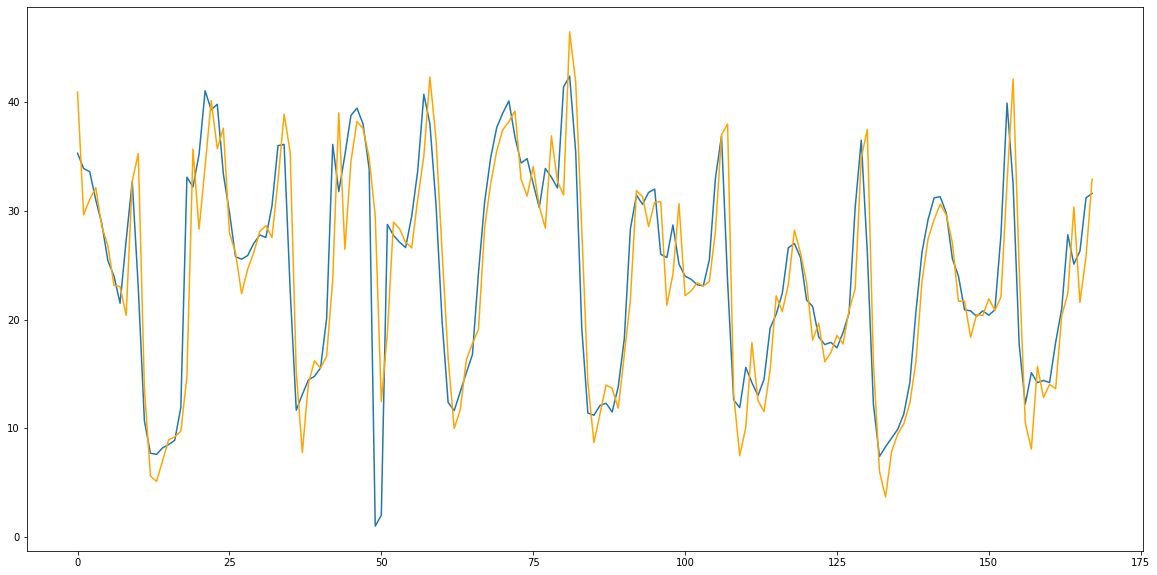

In [377]:
# report performance
rmse = mean_squared_error(raw_values[training_hours+1:], predictions)** 0.5
print('Test whole year RMSE: %.3f' % rmse)
# line plot of observed vs predicted

compare_time = -7*24*1
plt.figure(figsize=(20,10))
plt.plot(raw_values[compare_time:], )
plt.plot(predictions[compare_time:], color='orange')
print('shown RMSE: %.3f' % mean_squared_error(raw_values[compare_time:], predictions[compare_time:])** 0.5 )
plt.show()

In [208]:
print(len(raw_values))
print(len(predictions))
print(len(train_scaled))
print(len(test_scaled))

8759

# Multi step forecast (predicting the future)

There are at least four commonly used strategies for making multi-step forecasts.
 - Direct Multi-step Forecast Strategy.
 - Recursive Multi-step Forecast Strategy.
 - Direct-Recursive Hybrid Multi-step Forecast Strategies.
 - Multiple Output Forecast Strategy.

The direct method involves developing a separate model for each forecast time step. 
It implies a lot computational power and space. Complexity increases especially as
the number of time steps to be forecasted increases beyond the trivial.

The recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.
Because predictions are used in place of observations, the recursive strategy allows prediction errors to accumulate such that performance can quickly degrade as the prediction time horizon increases.

The direct and recursive strategies can be combined to offer the benefits of both methods.
For example, a separate model can be constructed for each time step to be predicted, but each model may use the predictions made by models at prior time steps as input values.

The multiple output strategy involves developing one model that is capable of predicting the entire forecast sequence in a one-shot manner. Multiple output models are more complex as they can learn the dependence structure between inputs and outputs as well as between outputs.

We decide using recursive strategy for simplicity and because we consider that climate
varies hourly and it will be difficult to find patterns in structures for a given time.
Also, other problem found on oher strategies is that a different model has to be computed
for a different lag, this raises the problem complexity.



## Prediction out of sample  

Forecast out of sample unknown data
The lstm univariate model was trained using **7 years**, so in order to get future values, for instance
havig data for hours: **1,2,3,4,5,6,7,8...** If we want to predict next **9th, 10th, 11th...**
data points.
The idea is as follows
The model expects **5557*24 = n inputs to predict 1 output**, and those inputs are the prior obs, then:

`X = asarray([[[0],[1],[2],[3],...,[n]]])`

and get future value like:

`n+1 = model.predict(X)` 

this will yield forecasting value, then we move the frame like:

`X = asarray([[    [1],[2],[3],...,[n],[n+1]]])`

get second future value like:

`n+2 = model.predict(X)` 

then:

`X = asarray([[        [2],[3],...,[n],[n+1],[n+2]]])`

then:

`X = asarray([[            [3],...,[n],[n+1],[n+2],[n+3]]])`

we keep on doing this m times:

`X = asarray([[ [n-m],...,[n+2],[n-1],[n],[n+1],[n+2],[n+3],...,[n+m]]])`


    



In [ ]:
#adds new element and removes the first element
def update_series_for_univariate_lstm(series, new_value):
    series = series.drop(series.index[0])
    series = series.append(pd.Series(new_value), len(series)) 
    return series  

def update_np_array_for_univariate_lstm(arr, new_value):
    del_arr = np.delete(arr,0, axis=0)    
    del_arr = np.append (del_arr, new_value)
    return del_arr  

aaa = np.array([1, 2, 3, 4])
print(aaa)
aaa = update_np_array_for_univariate_lstm(aaa,50)
print(aaa)
aaa = update_np_array_for_univariate_lstm(aaa,60)
print(aaa)
aaa = update_np_array_for_univariate_lstm(aaa,70)
print(aaa)
aaa = update_np_array_for_univariate_lstm(aaa,80)
print(aaa)

xtest_update = pd.Series(np.random.randn(3))
print(xtest_update)
xtest_update = update_series_for_univariate_lstm(xtest_update, 0.0)
print(xtest_update)
xtest_update = update_series_for_univariate_lstm(xtest_update, 1.0)
print(xtest_update)
xtest_update = update_series_for_univariate_lstm(xtest_update, 2.0)
print(xtest_update)
xtest_update = update_series_for_univariate_lstm(xtest_update, 3.0)
print(xtest_update)

In [355]:
def univariate_lstm_future(lstm_univariate_model, 
                           start_future, 
                           known_current_data, 
                           step_to_predict_future):
    #future
    future_predictions = list()   
    days_to_train  = 2557
    training_hours = days_to_train*24
    for i in range(step_to_predict_future):
        # transform data to be stationary
        _diff_values = difference(known_current_data, 1)
        # transform data to be supervised learning
        _supervised = timeseries_to_supervised(_diff_values, 1)
        _supervised_values = _supervised.values

        _train, _test = _supervised_values[:training_hours], _supervised_values[0]
        # fit scaler
        _scaler = MinMaxScaler(feature_range=(-1, 1))
        _scaler = scaler.fit(train)
        # transform train
        _train = _train.reshape(train.shape[0], train.shape[1])
        _train_scaled = scaler.transform(_train)
        # make one-step forecast
        __X, __y = _train_scaled[i, 0:-1], _train_scaled[i, -1]
        _yhat = forecast_lstm(lstm_model, 1, __X)
        # invert scaling
        _yhat = invert_scale(scaler, __X, _yhat)
        # invert differencing
        _yhat = inverse_difference(known_current_data, _yhat, len(_train_scaled)+1) #-i

        # store forecast
        future_predictions.append(_yhat)
        
        #adjust framing
        known_current_data = update_np_array_for_univariate_lstm(known_current_data, _yhat)
        
    #create dataframe with future data and corresponfing date
    dtf = pd.DataFrame (future_predictions, columns = ['Future'])
    dtf['date'] = pd.date_range(start=start_future, freq='1H', periods=len(future_predictions))
    dtf.set_index('date', inplace=True)
    return dtf 


    

In [ ]:
#len(df_workspace['NO2_st0'].values[:training_hours])
days_to_train  = 2557
training_hours = days_to_train*24
future_univariate_lstm = univariate_lstm_future(lstm_model, 
                           '2020-01-01 00:00:00', 
                           df_workspace['NO2_st0'].values[:training_hours+1], 
                           72)

plt.figure(figsize=(20,10))
plt.plot(df_workspace['NO2_st0']['2019-12-31 00:00:00':], )
plt.plot(future_univariate_lstm, color='green')
plt.show()
#future_univariate_lstm.plot()

In [368]:
#lstm_model.save("lstm_model_NO2_st0.pkl")

In [352]:
'''sqlQuery_tables = """\
     SELECT schemaname,relname,n_live_tup 
     FROM pg_stat_user_tables 
     ORDER BY n_live_tup DESC; """
df_tables = pd.DataFrame(runquery(sqlQuery_tables))
df_tables'''

'sqlQuery_tables = """     SELECT schemaname,relname,n_live_tup \n     FROM pg_stat_user_tables \n     ORDER BY n_live_tup DESC; """\ndf_tables = pd.DataFrame(runquery(sqlQuery_tables))\ndf_tables'

 - improvement ideas

at the end of each month, append new data to main datatable, then create other model 
keeping all old models and compare them

In [ ]:
!pip install fbprophet

In [ ]:
from fbprophet import Prophet

In [ ]:
days_to_train  = 2557
training_hours = days_to_train*24
df_workspace['NO2_st0'][:training_hours]

In [ ]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
model_univariate_prophet = Prophet() #interval_width=0.95)
model_univariate_prophet.fit()
future_prophet = model_univariate_prophet.make_future_dataframe(periods=72) #, freq='MS'
forecast_prophet = model_univariate_prophet.predict(future_prophet)

model_univariate_prophet.plot(forecast_prophet)



In [ ]:
future_dates = my_model.make_future_dataframe(periods=36)
future_dates.tail()

In [3]:
import itertools
p = [0, 1]
d = [0,   24]
q = [0]
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))  
pdq

[(0, 0, 0), (0, 24, 0), (1, 0, 0), (1, 24, 0)]